# Homework 5 - Carry Trade
By: Alex Huang

Date: February 12, 2024

UChicago ID: 12408153

## Imports and Config

In [170]:
# Operating
import os
import shutil
import platform
import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data
import statsmodels.api as sm
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import scipy as sp
import quandl

# Typing
from typing import Union

# Displays
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Configuration
pd.set_option('display.float_format', '{:,.4f}'.format)
plt.style.use('ggplot')
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5 

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
# default_colors = ['red', 'green', 'blue', 'orange']
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=default_colors)
plt.figure(figsize=(12, 6))



with open('api_key.txt', 'r') as file:
    API_KEY = file.read().strip()
if platform.system() == 'Windows':
    HOME_DIR = r'C:\Users\Alex\Desktop\Academic\UChicago\FINM 33150'
else:
    HOME_DIR = r'/Users/alexhuang/Documents/Academic/FINM 33150'


<Figure size 1200x600 with 0 Axes>

## Functions

In [247]:
class Compute:
    def lagged_tradeflow(timeseries: pd.DataFrame, time_column_name: str, volume_column_name: str, side_column_name: str, lag: int):
        directional_volume = timeseries[[time_column_name, volume_column_name, side_column_name]]
        directional_volume['directional_volume'] = (directional_volume[volume_column_name] * directional_volume[side_column_name])
        directional_volume = directional_volume.groupby(time_column_name)['directional_volume'].sum().to_frame()
        directional_volume = directional_volume.sort_index()
        org_cumsum = directional_volume['directional_volume'].cumsum()
        org_cumsum.name = 'cumsum'


        lagged_cumsum = org_cumsum.copy()
        lagged_cumsum.index = org_cumsum.index + (lag + 1)
        lagged_cumsum = lagged_cumsum.reindex(org_cumsum.index, method='ffill')
        lagged_cumsum.name = f'{lag}_lag_cumsum'

        new_timeseries = pd.concat([directional_volume, org_cumsum, lagged_cumsum], axis=1)
        new_timeseries[f'trailing_{lag}_tradeflow'] = org_cumsum - lagged_cumsum 
        return new_timeseries
    
    def forward_returns(timeseries: pd.DataFrame, time_column_name: str, price_column_name: str, volume_column_name, amt_lookfwd: int):
        avg_price = timeseries.groupby(time_column_name).agg({f'{price_column_name}': 'mean', f'{volume_column_name}': 'sum'}).sort_index().rename(columns={f'{price_column_name}': 'price', f'{volume_column_name}': 'total_volume'})
        # display(avg_price)
        forward_price = avg_price['price'].copy()
        forward_price.index = avg_price.index - (amt_lookfwd)
        # display(forward_price)

        forward_price = forward_price.reindex(avg_price.index, method='ffill')
        forward_price.name = f'{amt_lookfwd}_forward_price'
        # display(forward_price)
        forward_returns = forward_price / avg_price['price'] - 1
        forward_returns.name = f'{amt_lookfwd}_foward_returns'

        return pd.concat([avg_price, forward_price, forward_returns], axis=1)

    def signal(timeseries: pd.DataFrame, forecast_return_column_name: str, signal_trigger_threshold: float, forecast_duration: int):
        buy_signal_bgn:  pd.Series = pd.Series(np.where(timeseries[forecast_return_column_name] >= signal_trigger_threshold, 1, 0), index=timeseries.index)
        buy_signal_end:  pd.Series = -1 * buy_signal_bgn.shift(forecast_duration)
        buy_signal:      pd.Series = buy_signal_bgn + buy_signal_end

        sell_signal_bgn: pd.Series = pd.Series(np.where(timeseries[forecast_return_column_name] <= -signal_trigger_threshold, -1, 0), index=timeseries.index)
        sell_signal_end: pd.Series = -1 * sell_signal_bgn.shift(forecast_duration)
        sell_signal:     pd.Series = sell_signal_bgn + sell_signal_end

        net_signal:      pd.Series = buy_signal + sell_signal
        timeseries['net_signal'] = net_signal

        current_position: pd.Series = net_signal.cumsum()
        timeseries['current_position'] = current_position

        return timeseries

    # def strategy_performance(timseries: pd.DataFrame, signal_column_name: str, price_column_name:str, trading_cost: float=0, base_capital: float=1, pct_per_trade: float=0.001):
    #     returns = timseries[price_column_name].pct_change().fillna(0)
    #     pnl = (1 + (timseries[signal_column_name].shift(1) * (returns) * pct_per_trade)).cumprod() * base_capital


    #     return pnl

    def strategy_performance(timseries: pd.DataFrame, signal_column_name: str, price_column_name:str, trading_cost: float=0, base_capital: float=1, pct_per_trade: float=0.001):
        returns = timseries[price_column_name].pct_change().fillna(0)
        pnl = (1 + (timseries[signal_column_name].shift(1) * (returns) * pct_per_trade)).cumprod() * base_capital

        if trading_cost != 0:
            trading_cost = -1 * abs(timseries[signal_column_name] - timseries[signal_column_name].shift(1)) * trading_cost * base_capital * pct_per_trade
            pnl = pnl + trading_cost.cumsum()
        return pnl

    def performance_statistics(timeseries: pd.DataFrame, pnl_column_name: str):
        return_series = timeseries[pnl_column_name].pct_change().fillna(0)

        mean_return = np.mean(return_series)
        vol_return = np.std(return_series)

        # Calculate cumulative returns
        cumulative_returns = np.cumprod(1 + return_series)

        # Calculate previous peaks
        previous_peaks = np.maximum.accumulate(cumulative_returns)

        # Calculate drawdown
        drawdown = (cumulative_returns / previous_peaks) - 1

        # Calculate maximum drawdown
        max_drawdown = np.min(drawdown)


        portfolio_statistics = {}
        portfolio_statistics['Sharpe Ratio'] = [mean_return / vol_return]
        portfolio_statistics['Max Drawdown'] = [max_drawdown]

        return pd.DataFrame(portfolio_statistics)

    def swap_signal(time_series: pd.DataFrame, borrwoing_yield_column_name: str, lending_yield_column_name: str, min_spread: float=0.005):
        # Validation
        # TODO: Validation checks on series

        # Processing
        time_series['signal'] = time_series[lending_yield_column_name] >= (time_series[borrwoing_yield_column_name] + min_spread)
        return time_series
    
    def duration(coupon_rate: Union[float, pd.Series], freq_per_year: float, years: float) -> float:
        if isinstance(coupon_rate, float):
            df = pd.DataFrame({'coupons': [coupon_rate] * (freq_per_year * years), 'periods': np.array(range(1, int(years * freq_per_year) + 1))/freq_per_year })
            df.iloc[-1,0] += 1
            df['time_weighted_coupon'] = df['coupons'] * df['periods']

            dur = df['time_weighted_coupon'].sum() / df['coupons'].sum()
            return dur
        elif isinstance(coupon_rate, pd.Series):
            durations = []
            for cpn_rate in coupon_rate.values:
                durations.append(Compute.duration(cpn_rate, freq_per_year, years))
            return pd.Series(durations, index=coupon_rate.index, name='duration')

    def carry_trade(timeseries:  pd.DataFrame, 
                borrow_rate_column_name: str,               # interest rate
                lend_rate_column_name: str,                 # interest rate
                signal_column_name: str,
                borrow_fx_rate_to_usd_column_name: str,     # fx rate
                lend_fx_rate_to_usd_column_name: str,       # fx rate
                notional_trade_amount: float,
                starting_capital_amount: float
        ) -> pd.DataFrame:
        timeseries = timeseries.reindex(pd.date_range(timeseries.index.min(), timeseries.index.max(), freq='W'))
        timeseries['USD_pay_interest'] = (timeseries[borrow_rate_column_name] / 52 * (notional_trade_amount - starting_capital_amount) * (timeseries[borrow_fx_rate_to_usd_column_name] - timeseries[borrow_fx_rate_to_usd_column_name].shift(1)))#.shift(1)
        # timeseries['USD_get_interest'] = (notional_trade_amount * timeseries[lend_fx_rate_to_usd_column_name].shift(1) * ((timeseries[lend_rate_column_name]/52) + c)) / timeseries[lend_fx_rate_to_usd_column_name])
        
        # Step 1: Convert
        timeseries['USD_get_interest'] = (notional_trade_amount * timeseries[lend_fx_rate_to_usd_column_name].shift(1)) # in EGP
        # log = timeseries['USD_get_interest'].copy()

        # Step 2: Get Accrued Interest and Price change
        timeseries['USD_get_interest'] = timeseries['USD_get_interest'] * (1 + (timeseries[lend_rate_column_name] / 52 + (-Compute.duration(timeseries[lend_rate_column_name], 4, 5)) * (timeseries[lend_rate_column_name] - timeseries[lend_rate_column_name].shift(1))))

        # Step 3: Convert back
        timeseries['USD_get_interest'] = timeseries['USD_get_interest'] / timeseries[lend_fx_rate_to_usd_column_name]

        # Step 4: Subtract EGP
        timeseries['USD_get_interest'] = timeseries['USD_get_interest'] - notional_trade_amount

        timeseries['USD_net_PnL_change'] = timeseries['USD_get_interest'] - timeseries['USD_pay_interest']
        timeseries['USD_net_PnL'] = timeseries['USD_net_PnL_change'].cumsum()

        return timeseries
 

In [266]:
class PlotDynamics:
    def plot_returns_ts_hist(returns_series: pd.Series, ticker_symbol: str, figsize: tuple=(12,6), bins: int=20, use_steps_post: bool=False):
        if not isinstance(returns_series, pd.Series): raise TypeError("returns_series must be type pd.DataFrame.")
        if not isinstance(ticker_symbol, str): raise TypeError("returns_series must be type str.")
        # if not pd.api.types.is_datetime64_any_dtype(returns_series.index): raise TypeError("returns_series.index must be datetime type.")
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        if use_steps_post:
            ax1.plot(returns_series.index, returns_series.values, drawstyle='steps-post')
        else:
            ax1.plot(returns_series.index, returns_series.values)
        ax1.set_title(f'{ticker_symbol} Returns Time Series')
        ax1.set_xlabel(f'Time')
        ax1.set_ylabel(f'{ticker_symbol} Returns')

        ax2.hist(returns_series.values, bins=bins, color='skyblue', edgecolor='black')
        ax2.set_title(f'{ticker_symbol} Returns Histogram')
        ax2.set_xlabel(f'Returns')
        ax2.set_ylabel(f'{ticker_symbol} Returns Frequency')

        plt.tight_layout()
        plt.show()

    def plot_ts_hist(timeseries: pd.Series, ticker_symbol: str, x1label: str='Time', y1label: str='Value', x2label: str='Time', y2label: str='Frequency', title1: str='Time Series', title2: str='Histogram', figsize: tuple=(12,6), bins: int=20, use_steps_post: bool=False):
        if not isinstance(timeseries, pd.Series): raise TypeError("returns_series must be type pd.DataFrame.")
        if not isinstance(ticker_symbol, str): raise TypeError("returns_series must be type str.")
        # if not pd.api.types.is_datetime64_any_dtype(returns_series.index): raise TypeError("returns_series.index must be datetime type.")
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        if use_steps_post:
            ax1.plot(timeseries.index, timeseries.values, drawstyle='steps-post')
        else:
            ax1.plot(timeseries.index, timeseries.values)
        ax1.set_title(title1)
        ax1.set_xlabel(x1label)
        ax1.set_ylabel(y1label)

        ax2.hist(timeseries.values, bins=bins, color='skyblue', edgecolor='black')
        ax2.set_title(title2)
        ax2.set_xlabel(x2label)
        ax2.set_ylabel(y2label)

        plt.tight_layout()
        plt.show()

    def plot_price_volume(ticker_df: pd.DataFrame, ticker_symbol: str, y1_label: str="Adjusted Close Price", y2_label: str="Adjusted Volume", x_label: str="Time", figsize: tuple=(12,6), price_column_name: str='adj_close', volume_column_name: str='adj_volume', use_steps_post: bool=False):
        if not isinstance(ticker_df, pd.DataFrame): raise TypeError("ticker_df must be type pd.DataFrame.")
        if not isinstance(ticker_symbol, str): raise TypeError("ticker_symbol must be type str.")
        if price_column_name not in ticker_df.columns: raise KeyError(f"'{price_column_name}' not found in dataframe.")
        if volume_column_name not in ticker_df.columns: raise KeyError(f"'{volume_column_name}' not found in dataframe.")
        # if not pd.api.types.is_datetime64_any_dtype(ticker_df.index): raise TypeError("ticker_df.index must be datetime type.")

        fig, ax1 = plt.subplots(figsize=figsize)

        # Adjusted Clost Price
        if use_steps_post:
            ax1.plot(ticker_df.index, ticker_df[f'{price_column_name}'], label=y1_label, color='blue', drawstyle='steps-post')
        else:
            ax1.plot(ticker_df.index, ticker_df[f'{price_column_name}'], label=y1_label, color='blue')
        ax1.set_xlabel(x_label)
        ax1.set_ylabel(y1_label, color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.legend(loc='upper left')

        # Volume
        ax2 = ax1.twinx()
        if use_steps_post:
            ax2.plot(ticker_df.index, ticker_df[f'{volume_column_name}'], label=y2_label, color='green', alpha=0.3, drawstyle='steps-post')
        else:
            ax2.plot(ticker_df.index, ticker_df[f'{volume_column_name}'], label=y2_label, color='green', alpha=0.3)
        ax2.set_ylabel(y2_label, color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        ax2.legend(loc='upper right')
        

        # Show the plot
        plt.title(f'{ticker_symbol} Price and Volume')
        plt.show()
    

    def plot_multiple_ts(series_to_plot: Union[list[pd.Series], pd.Series], series_labels: Union[list[str], str], ylabel: str="Values", xlabel: str="Date", title: str="Time Series", figsize: tuple=(12,6), alphas: list[float]=None, use_step_post: bool=False, group: bool=True):
        # Perform type checking
        if not isinstance(xlabel, str): raise TypeError("xlabel must be type str.")
        if not isinstance(ylabel, str): raise TypeError("ylabel must be type str.")
        if not isinstance(title, str): raise TypeError("title must be type str.")

        if alphas is None: alphas = [1] * len(series_to_plot)

        # NOTE: UPDATE
        # timeseries = pd.concat(series_to_plot, axis=1).sort_index()
        # timeseries.plot.line(xlabel=xlabel, ylabel=ylabel, title=title, alpha=alphas[0])
        # plt.show()
        # return
        # NOTE: END

        
        plt.figure(figsize=figsize)
        if isinstance(series_to_plot, list) and isinstance(series_labels, list):
            series: pd.Series
            time_series: pd.DataFrame
            if group:
                time_series = pd.concat(series_to_plot, axis=1)
                fig, ax = plt.subplots()
                for col_name, series_label, alpha in zip(time_series.columns, series_labels, alphas):
                    time_series[col_name].plot.line(drawstyle='steps-post', label=series_label, ax=ax, figsize=figsize, alpha=alpha)
                    ax.set_xlabel(xlabel)
                    ax.set_ylabel(ylabel)
                    ax.set_title(title)
                    ax.legend(series_labels)
                    # ax.show()
            else:
                for series, label, alpha in zip(series_to_plot, series_labels, alphas):
                    if isinstance(series, pd.Series) and isinstance(label, str):
                        if use_step_post:
                            plt.plot(series.index, series.values, label=label, alpha=alpha, drawstyle='steps-post')
                        else:
                            plt.plot(series.index, series.values, label=label, alpha=alpha)
                    else:
                        raise TypeError("series_to_plot must be type pd.Series or type list[pd.Series].")
        elif isinstance(series_to_plot, pd.Series) and isinstance(series_labels, str):
            series: pd.Series = series_to_plot
            label: str = series_labels
            alpha: float = alphas[0]
            if use_step_post:
                plt.plot(series.index, series.values, label=label, alpha=alpha, drawstyle='steps-post')
            else:
                plt.plot(series.index, series.values, label=label, alpha=alpha)
        else:
            raise TypeError("series_to_plot must be type pd.Series or type list[pd.Series].")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend(series_labels)
        plt.show()


    def plot_dual_axis_timeseries(x: pd.Series, y1: list[pd.Series], y2: list[pd.Series], y1_series_names: list[str]=None, y2_series_names: list[str]=None, xlabel: str='Time', y1label: str='y1', title: str='Dual Time Series Plots', y2label: str='y2', y1color: str='tab:blue', y2color: str='tab:red', figsize: tuple[int,int]=(12,6), alpha: list[int]=None, use_steps_post: list[bool]=None):
        """ 
        Plot a dual y-axis time series.

        Parameters:
            x (pd.Series): The x-axis data (time series).
            y1 (list[pd.Series]): List of y-axis data for the left y-axis.
            y2 (list[pd.Series]): List of y-axis data for the right y-axis.

        Returns:
            None
        """
        if alpha is None:
            alpha = [1] * (len(y1) + len(y2))
        if use_steps_post is None:
            use_steps_post = [False] * (len(y1) + len(y2))
        if y1_series_names is None:
            y1_series_names = [f'y1.{i}' for i in range(len(y1))]
        if y2_series_names is None:
            y2_series_names = [f'y2.{i}' for i in range(len(y2))]

        fig, ax1 = plt.subplots(figsize=figsize)

        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(y1label, color=y1color)

        alpha_index = 0
        use_steps_post_index = 0
        for y1_data, y1name in zip(y1, y1_series_names):
            if use_steps_post[use_steps_post_index] == True:
                ax1.plot(x, y1_data, color=y1color, alpha=alpha[alpha_index], label=y1name, drawstyle='steps-post')
            else:
                ax1.plot(x, y1_data, color=y1color, alpha=alpha[alpha_index], label=y1name)
            use_steps_post_index += 1
            alpha_index += 1

        ax2 = ax1.twinx()
        ax2.set_ylabel(y2label, color=y2color)
        for y2_data, y2name in zip(y2, y2_series_names):
            if use_steps_post[use_steps_post_index] == True:
                ax2.plot(x, y2_data, color=y2color, alpha=alpha[alpha_index], label=y2name, drawstyle='steps-post')
            else:
                ax2.plot(x, y2_data, color=y2color, alpha=alpha[alpha_index], label=y2name)
            use_steps_post_index += 1
            alpha_index += 1
        
        ax1.legend(loc='best')
        ax2.legend(loc='best')

        # ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
        # ax2.legend(loc='upper right', bbox_to_anchor=(1.1, 0.9))
        plt.title(title)
        plt.show()

    def plot_regression_statistics(X: pd.Series, y: pd.Series, use_bias: bool=True, title: str="Regression Plot"):
        if use_bias:
            new_X = sm.add_constant(X)
        else:
            new_X = X

        model = sm.OLS(y, new_X)
        results = model.fit()
        predicted_values = results.predict(new_X)

        plt.scatter(X, y, label='Data', alpha=0.5)

        # Plot the regression line
        plt.plot(X, predicted_values, color='blue', label='Regression Line')

        # Add labels and legend
        plt.xlabel(X.name)
        plt.ylabel(y.name)
        plt.title(title)
        plt.legend()

        # Show plot
        plt.show()
        display(results.summary())

        return results



In [6]:
class DataFetching:
    def grab_quandl_table(
        table_path,
        avoid_download=False,
        replace_existing=False,
        date_override=None,
        allow_old_file=False,
        **kwargs,
    ):
        root_data_dir = os.path.join(HOME_DIR, "quandl_data_table_downloads")
        data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
        if avoid_download and os.path.exists(data_symlink):
            print(f"Skipping any possible download of {table_path}")
            return data_symlink
        
        table_dir = os.path.dirname(data_symlink)
        if not os.path.isdir(table_dir):
            print(f'Creating new data dir {table_dir}')
            os.makedirs(table_dir)

        if date_override is None:
            my_date = datetime.datetime.now().strftime("%Y%m%d")
        else:
            my_date = date_override
        data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

        if os.path.exists(data_file):
            file_size = os.stat(data_file).st_size
            if replace_existing or not file_size > 0:
                print(f"Removing old file {data_file} size {file_size}")
            else:
                print(
                    f"Data file {data_file} size {file_size} exists already, no need to download"
                )
                return data_file

        dl = quandl.export_table(
            table_path, filename=data_file, api_key=API_KEY, **kwargs
        )
        file_size = os.stat(data_file).st_size
        if os.path.exists(data_file) and file_size > 0:
            print(f"Download finished: {file_size} bytes")
            if not date_override:
                if os.path.exists(data_symlink):
                    print(f"Removing old symlink")
                    os.unlink(data_symlink)
                print(f"Creating symlink: {data_file} -> {data_symlink}")
                current_os = platform.system()
                if current_os == 'Windows':
                    shutil.copy(
                        data_file, data_symlink
                    )
                else:
                    os.symlink(
                        data_file, data_symlink,
                    )
        else:
            print(f"Data file {data_file} failed download")
            return
        return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"



    def fetch_quandl_table(table_path, avoid_download=True, **kwargs) -> pd.DataFrame:
        return pd.read_csv(
            DataFetching.grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
        )




# Table of Contents

> - [**I. Introduction: Overview and Objective**](#i-introduction-overview-and-objective)
   >> - [1. Overview](#1-overview)
   >> - [2. Objective](#2-objective)
> - [**II. Gathering Data: Fetching, Filtering, Cleaning, and Configuration**](#ii-gathering-data-fetching-filtering-cleaning-and-configuration)
   >> - [1. Fetching and Filtering](#1-fetching-and-filtering)
   >> - [2. Cleaning](#2-cleaning)
   >> - [3. Configuration](#3-configuration)
> - [**III. Dynamics Of The Underlying**](#iii-dynamics-of-the-underlying)
   >> - [1. Price Dynamics](#1-price-dynamics)
      >>> - [BTC-USD Pair Dynamics](#btc-usd-pair-dynamics)
      >>> - [ETH-BTC Pair Dynamics](#eth-btc-pair-dynamics)
      >>> - [ETH-USD Pair Dynamics](#eth-usd-pair-dynamics)
   >> - [2. Return Dynamics](#2-return-dynamics)
      >>> - [BTC-USD Forward Return Dynamics](#btc-usd-forward-return-dynamics)
      >>> - [ETH-BTC Forward Return Dynamics](#eth-btc-forward-return-dynamics)
      >>> - [ETH-USD Forward Return Dynamics](#eth-usd-forward-return-dynamics)
   >> - [3. Trade Flow Momentum](#3-trade-flow-momentum)
      >>> - [BTC-USD Trade Flow Time Series](#btc-usd-trade-flow-time-series)
      >>> - [ETH-BTC Trade Flow Time Series](#eth-btc-trade-flow-time-series)
      >>> - [ETH-USD Trade Flow Time Series](#eth-usd-trade-flow-time-series)
   >> - [4. Regression: Trade Flow on Future Returns](#4-regression-trade-flow-on-future-returns)
      >>> - [BTC-USD Regression: Trade Flow on Future Returns](#btc-usd-regression-trade-flow-on-future-returns)
      >>> - [ETH-BTC Regression: Trade Flow on Future Returns](#eth-btc-regression-trade-flow-on-future-returns)
      >>> - [ETH-USD Regression: Trade Flow on Future Returns](#eth-usd-regression-trade-flow-on-future-returns)
> - [**IV. Trading Strategy:**](#iv-trading-strategy)
   >> - [1. Fixed Beta Strategy](#1-fixed-beta-strategy)
   >> - [2. Rolling Beta Strategy](#2-rolling-beta-strategy)
> - [**V. Research Conclusion**](#v-research-conclusion)
   >> - [1. Conclusion Report](#1-conclusion-report)


## I. Introduction: Overview and Objective

### 1. Overview
***

In this assignment we will evaluate trade flow data to identify profit opportunities in three cryptotoken markets. Utilizing preprocessed level 3 exchange messages from the Coinbase WebSocket API, we will split the data into training and test sets and then compute τ-interval trade flow just prior to each trade data point. By regressing these flow values against T-second forward returns in the training set, we will derive a coefficient β for regression. Subsequently, they predict returns for each data point in the test set and assess trading opportunities considering trading cost assumptions, examining metrics like Sharpe ratios, drawdowns, and tails.

### 2. Objective 
***

The objective is to develop a systematic approach to leverage trade flow data for profit prediction in cryptotoken markets. We will implement code to compute trade flow prior to each trade, predict returns based on regression analysis, and evaluate trading opportunities in the test set. Through analyzing metrics such as Sharpe ratios and drawdowns, students will assess the effectiveness of return predictions. Furthermore, we will examine the reliability of regression coefficient β, determine appropriate thresholds for trading based on return predictions, and consider the implications of using longer training and test periods for more robust analysis.

## II. Gathering Data: Fetching, Filtering, Cleaning, and Configuration

### 1. Fetching and Filtering
***

Our data source is from the CoinBase API. Mannually downloaded and read into the system.

In [76]:
# spot FX rates for the dollar versus pound
fx_rates_table = DataFetching.fetch_quandl_table('EDI/CUR', avoid_download=False)
fx_rates_table['date'] = pd.to_datetime(fx_rates_table['date'], format='%Y-%m-%d')

Data file /Users/alexhuang/Documents/Academic/FINM 33150/quandl_data_table_downloads/EDI/CUR_20240215.zip size 7449838 exists already, no need to download


In [8]:
ois_table = pd.read_csv(r'./data/Bank of England  Database.csv')
ois_table.columns = ['date', 'ois']
ois_table['ois'] = ois_table['ois'] / 100
ois_table

date    ois
0     09 Feb 24 0.0519
1     08 Feb 24 0.0519
2     07 Feb 24 0.0519
3     06 Feb 24 0.0519
4     05 Feb 24 0.0519
...         ...    ...
6844  08 Jan 97 0.0596
6845  07 Jan 97 0.0594
6846  06 Jan 97 0.0590
6847  03 Jan 97 0.0603
6848  02 Jan 97 0.0594

[6849 rows x 2 columns]

In [9]:
yield_curve_table = pd.read_csv(r'./data/InferredYieldCurves_2024.tab', delimiter='\t')
yield_curve_table

Unnamed: 0        shortname tenor        date  yield
0             3401   Arab Rep Egypt   10Y  2010-01-04 0.0759
1             3402   Arab Rep Egypt   10Y  2010-01-05 0.0746
2             3403   Arab Rep Egypt   10Y  2010-01-06 0.0743
3             3404   Arab Rep Egypt   10Y  2010-01-07 0.0736
4             3405   Arab Rep Egypt   10Y  2010-01-08 0.0730
...            ...              ...   ...         ...    ...
324689      323564  Utd Mexican Sts    6M  2024-01-29 0.0534
324690      323565  Utd Mexican Sts    6M  2024-01-30 0.0533
324691      323566  Utd Mexican Sts    6M  2024-01-31 0.0533
324692      323567  Utd Mexican Sts    6M  2024-02-01 0.0528
324693      323568  Utd Mexican Sts    6M  2024-02-02 0.0536

[324694 rows x 5 columns]

### 2. Cleaning 
***
We clean the data by sorting by the clock time of the trading data and the book data.

In [10]:
# Egyptian Pound, Hungarian Forint, Costa Rican Colon and Romanian Leu from the earliest possible date through now
if 'shortname' in yield_curve_table.columns and 'tenor' in yield_curve_table.columns:
    yield_curve_table = yield_curve_table.set_index(['shortname', 'tenor'])

In [11]:
interested_countries = ['Arab Rep Egypt', 'Hungary', 'Rep Costa Rica', 'Romania']
yield_curve_table = yield_curve_table.loc[yield_curve_table.index.get_level_values('shortname').isin(interested_countries)]

In [24]:
yield_curve_table['date'] = pd.to_datetime(yield_curve_table['date'], format='%Y-%m-%d')

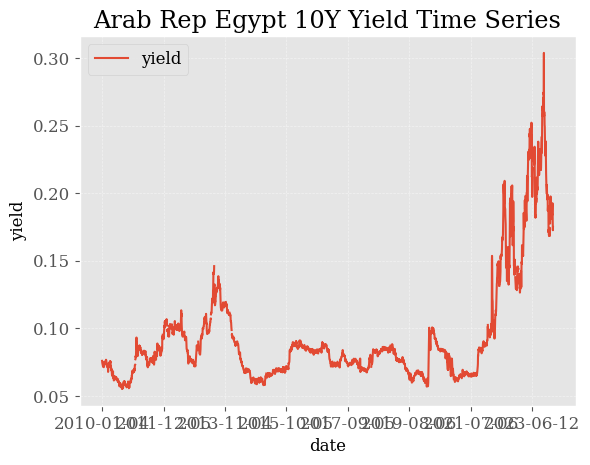

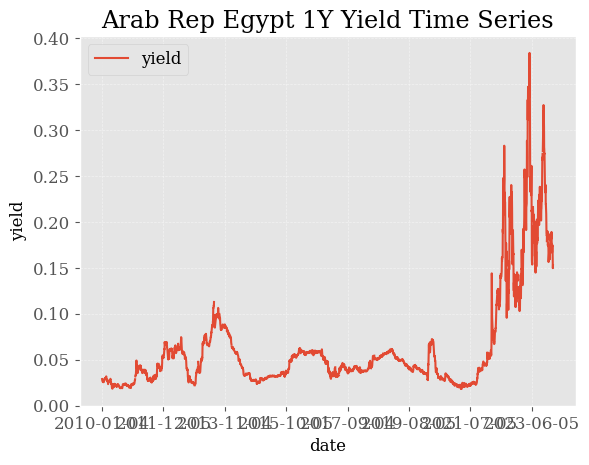

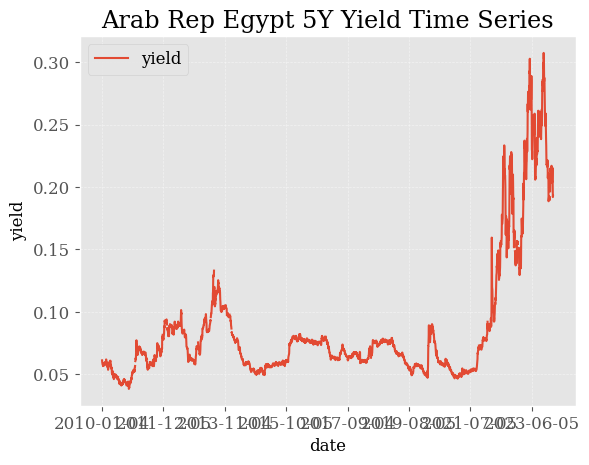

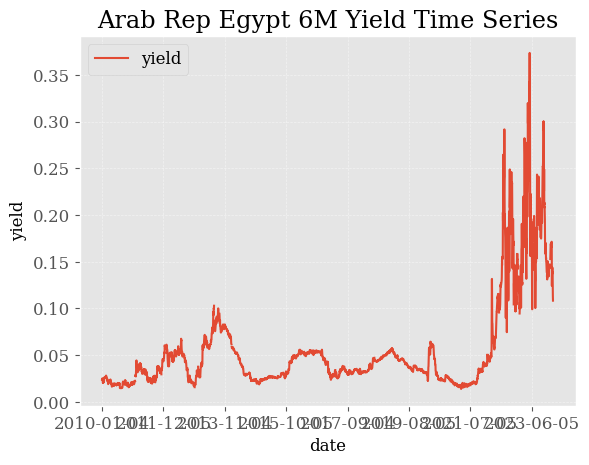

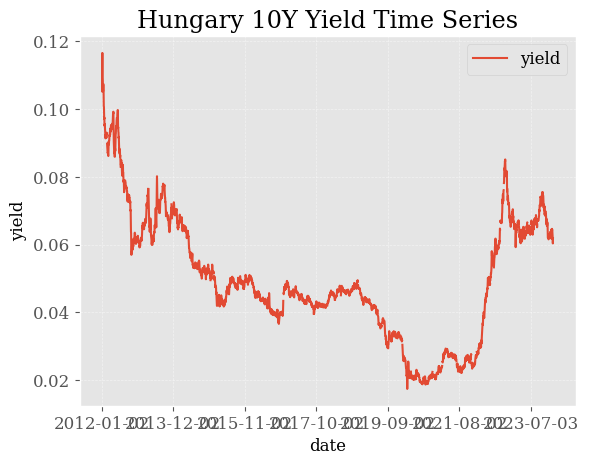

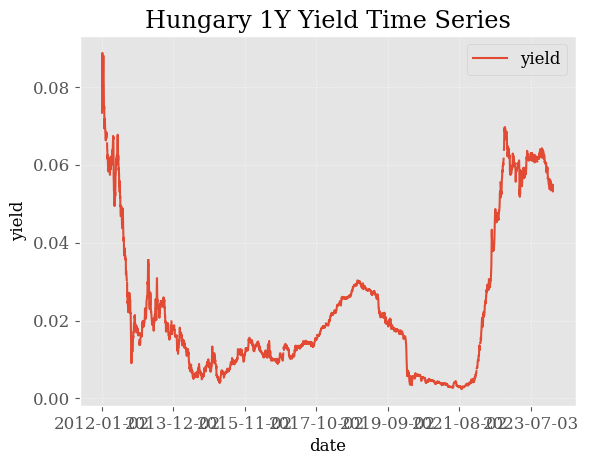

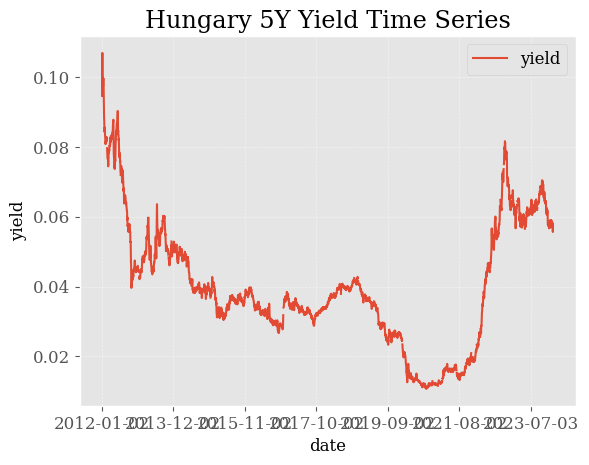

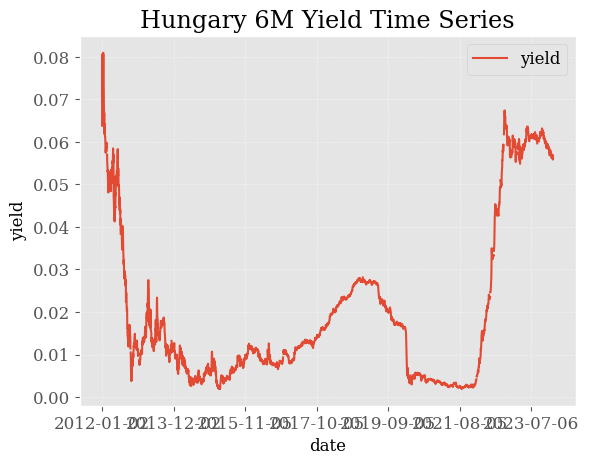

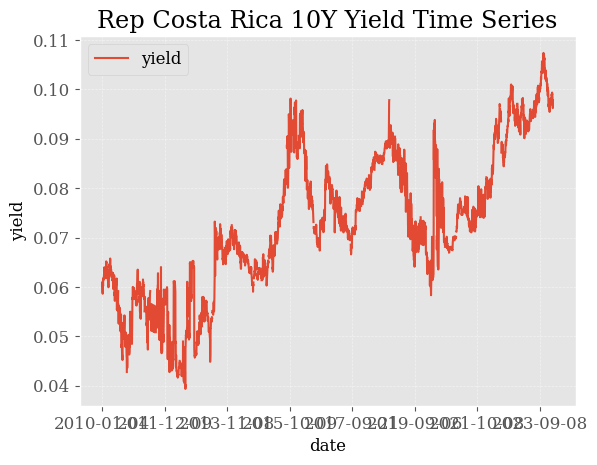

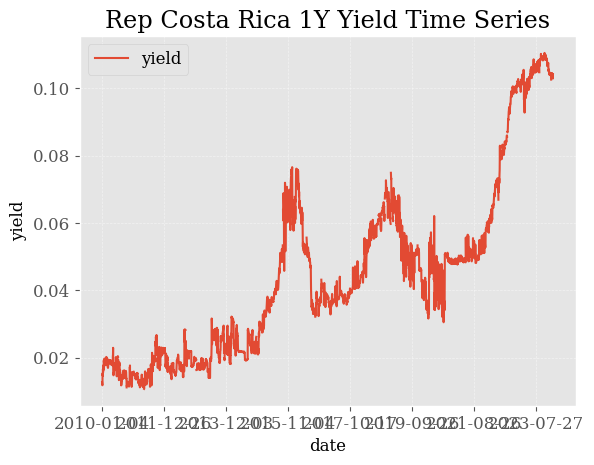

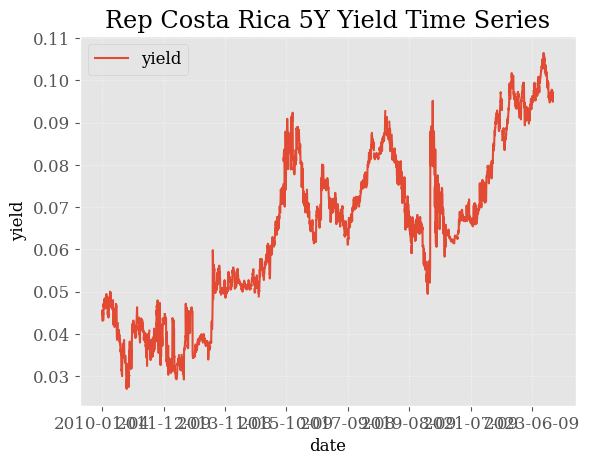

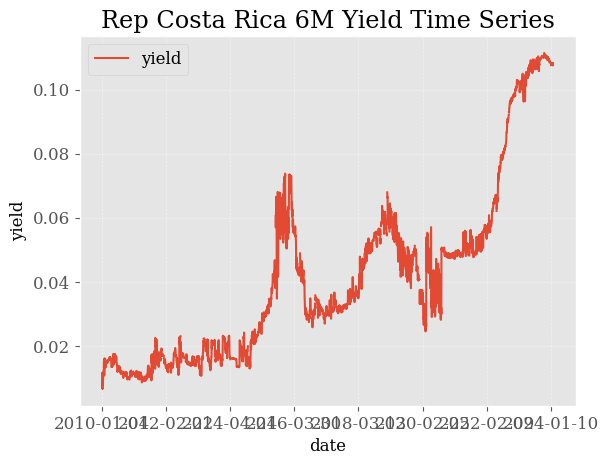

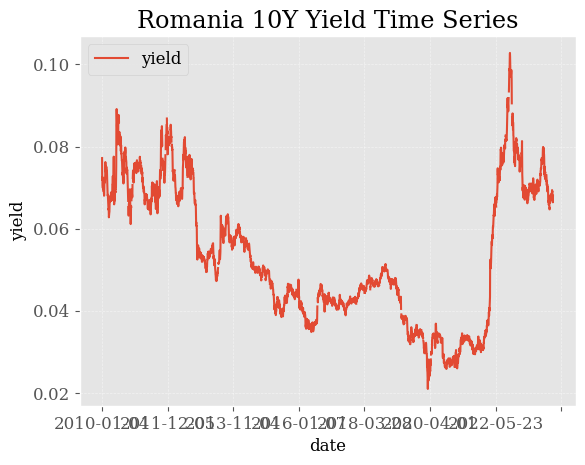

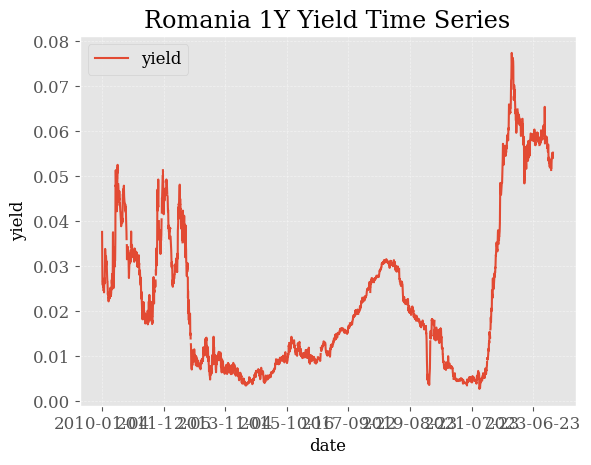

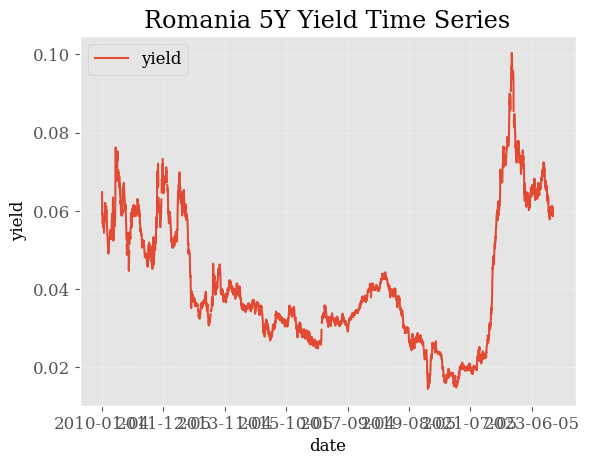

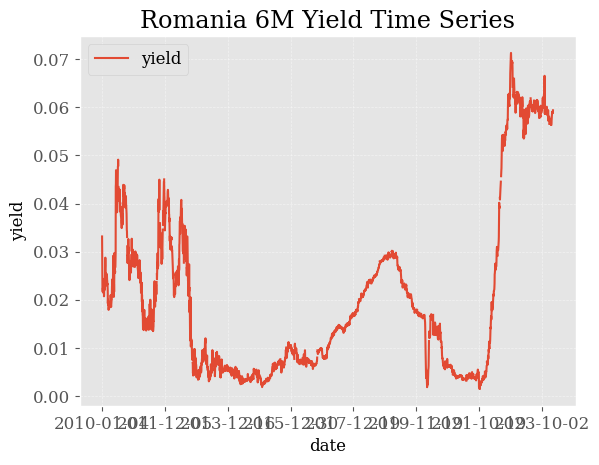

In [12]:
for country in sorted(yield_curve_table.index.get_level_values('shortname').unique()):
    for tenor in sorted(yield_curve_table.index.get_level_values('tenor').unique()):
        yield_curve_table.loc[(country, tenor)][['date', 'yield']].reset_index().set_index('date').plot.line(
            xlabel='date',
            ylabel='yield',
            title=f'{country} {tenor} Yield Time Series'
        )

### 3. Configuration
***
We configure our data by splitting the data of each pair (BTC-USD, ETH-BTC, ETH-USD) into a training set and a testing set. This is set via the `train_split_portion` variable.


**Tables:**
***
**Book Tables:**

> `train_book_btc_usd_df`: Training portion of the book data for BTC-USD

> `test_book_btc_usd_df`: Testing portion of the book data for BTC-USD

> `train_book_eth_btc_df`: Training portion of the book data for ETH-BTC

> `test_book_eth_btc_df`: Testing portion of the book data for ETH-BTC

> `train_book_eth_btc_df`: Training portion of the book data for ETH-USD

> `test_book_eth_btc_df`: Testing portion of the book data for ETH-USD

**Trade Tables:**

> `train_trades_btc_usd_df`: Training portion of the trade data for BTC-USD

> `test_trades_btc_usd_df`: Testing portion of the btradedata for BTC-USD

> `train_trades_eth_btc_df`: Training portion of the trade data for ETH-BTC

> `test_trades_eth_btc_df`: Testing portion of the btradedata for ETH-BTC

> `train_trades_eth_btc_df`: Training portion of the trade data for ETH-USD

> `test_trades_eth_btc_df`: Testing portion of the btradedata for ETH-USD

## III. Dynamics Of The Underlying

### 1. Yield Dynamics
***

<u>**Parameters:**</u>

> `LAGGED_TRADEFLOW_TIME` = 5 seconds (This is the main parameter to compute the T second window trade flow.)

> `FORWARD_RETURN_TIME_INTERVAL` = 5 seconds (This is the main parameter to compute the Tau second window for forward returns.)


<u>**Overview of Dynamics:**</u>

We will take a quick look at the dynamics of the trading prices for each pair; BTC-USD, ETH-BTC, and ETH-USD. This will give us a better understanding of the data we're working with.

In [13]:
if 'date' in ois_table.columns:
    ois_table['date'] = pd.to_datetime(ois_table['date'], format='%d %b %y')
    ois_table = ois_table.set_index('date').sort_index()

ois_table['ois_50bps'] = ois_table['ois'] + 0.005

ois_min_date = ois_table.index.min()
ois_max_date = ois_table.index.max()

#### OIS Yield
***

<Figure size 1200x600 with 0 Axes>

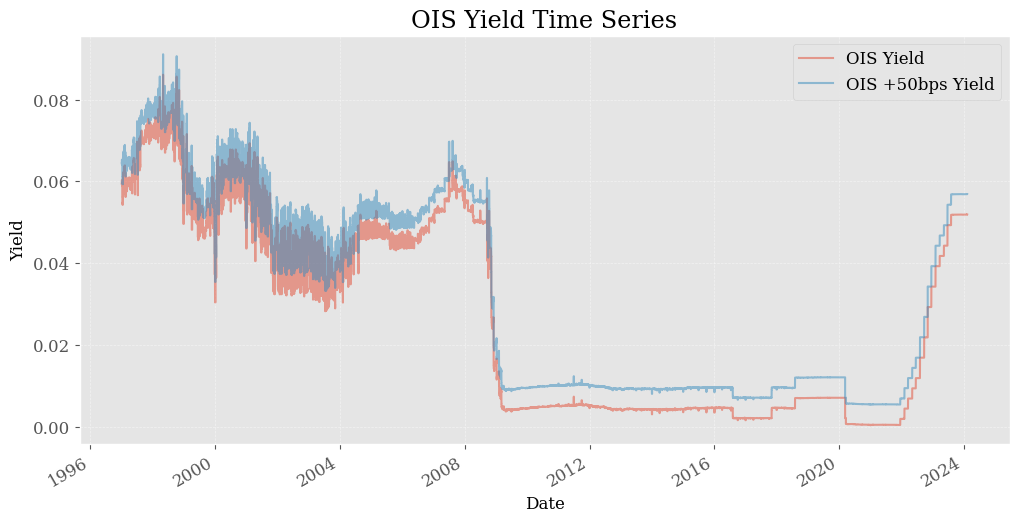

In [14]:
PlotDynamics.plot_multiple_ts(
    [
        ois_table['ois'],
        ois_table['ois_50bps'],
    ],
    [
        'OIS Yield',
        'OIS +50bps Yield',
    ],
    ylabel='Yield',
    xlabel='Date',
    title='OIS Yield Time Series',
    alphas=[0.5,0.5]
)

#### Swap Rates
***

<Figure size 1200x600 with 0 Axes>

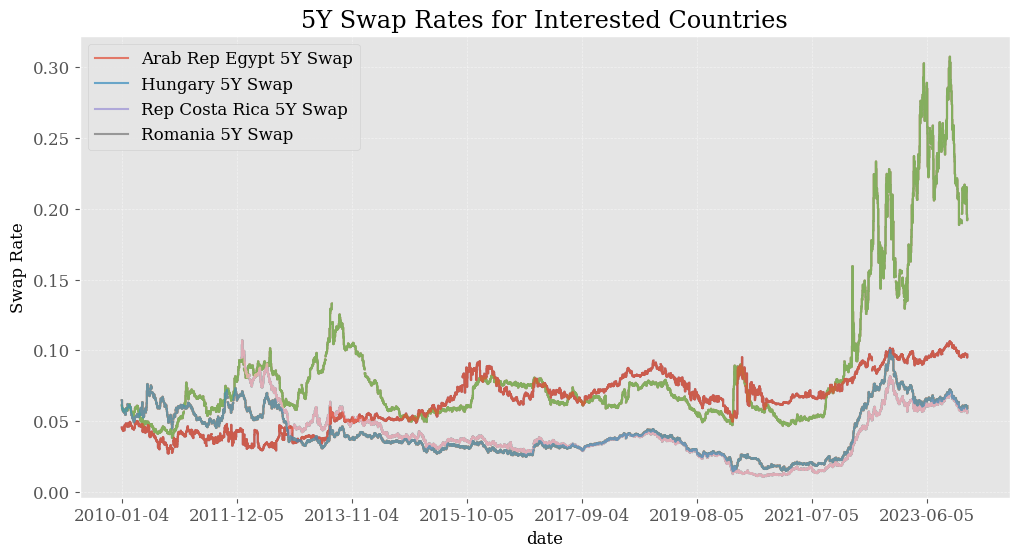

In [15]:
PlotDynamics.plot_multiple_ts(
    [
        yield_curve_table.loc[(country, '5Y'), ['date', 'yield']].reset_index().set_index('date')['yield'] for country in sorted(yield_curve_table.index.get_level_values('shortname').unique())
    ],
    [
        f'{country} 5Y Swap' for country in sorted(yield_curve_table.index.get_level_values('shortname').unique())
    ],
    xlabel='date',
    ylabel='Swap Rate',
    title='5Y Swap Rates for Interested Countries',
    alphas=[0.7] * 4,
    group=True

)

#### Correlation between Swap Rates
***

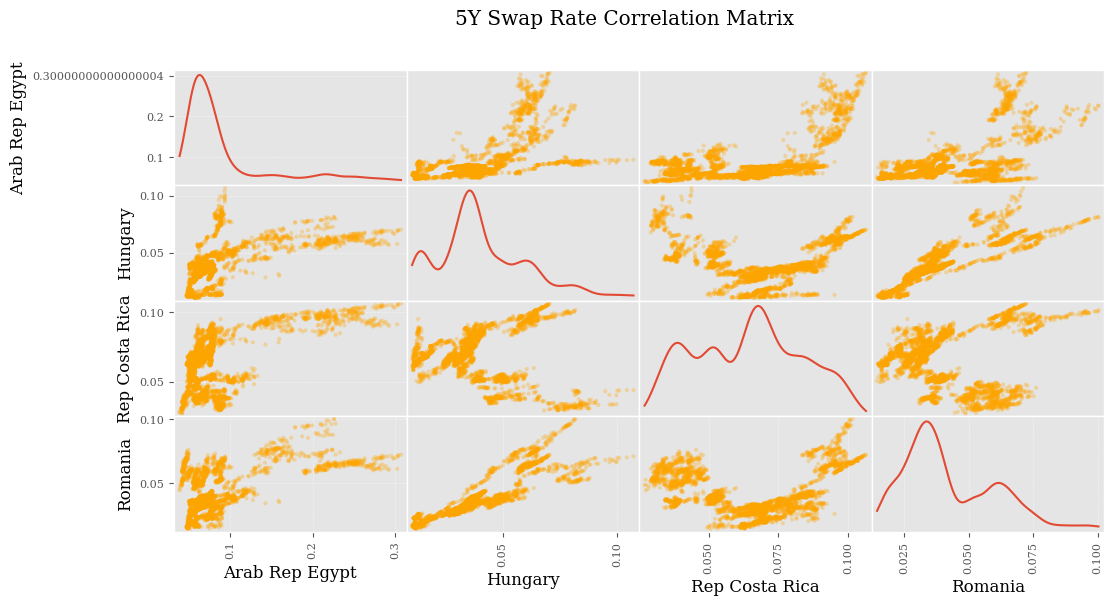

In [190]:
y5_yield_curve_df = yield_curve_table[(yield_curve_table.index.get_level_values('shortname').isin(interested_countries)) & (yield_curve_table.index.get_level_values('tenor') == '5Y')]

pivot_df = y5_yield_curve_df.reset_index().pivot(columns='shortname', index='date', values='yield')

# Create scatter matrix
pd.plotting.scatter_matrix(pivot_df, figsize=(12, 6), alpha=0.3, color='orange', diagonal='kde')

# Set the title for the entire figure
plt.suptitle('5Y Swap Rate Correlation Matrix')

plt.show()

# y5_yield_curve_df.reset_index()[['shortname', 'date', 'yield']].pivot(columns='shortname', index='date', values='yield')
# y5_yield_curve_df.name

### 2. Foreign Exchange Rate Dynamics
***

#### FX Rate Time Series
***

### GBP Foreign Exchange Rate Time Series
***
    

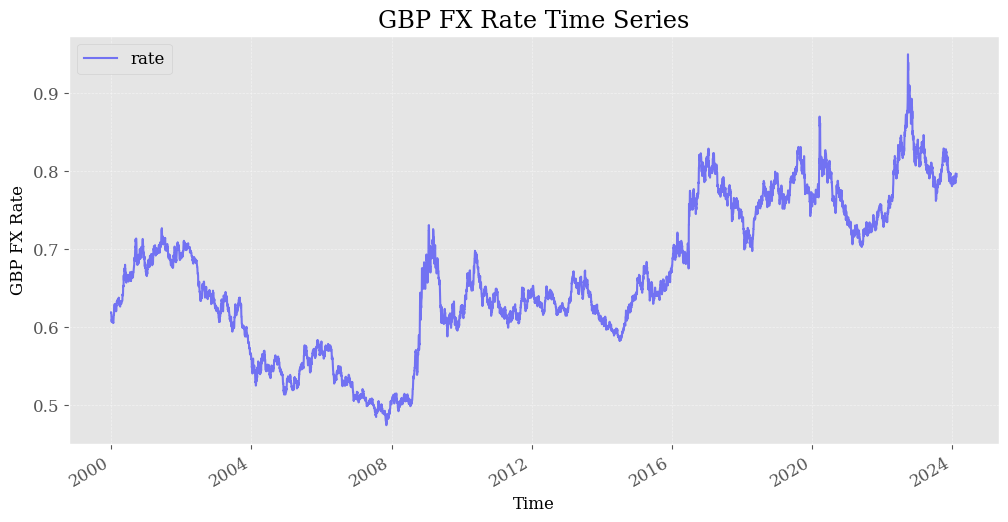

### EGP Foreign Exchange Rate Time Series
***
    

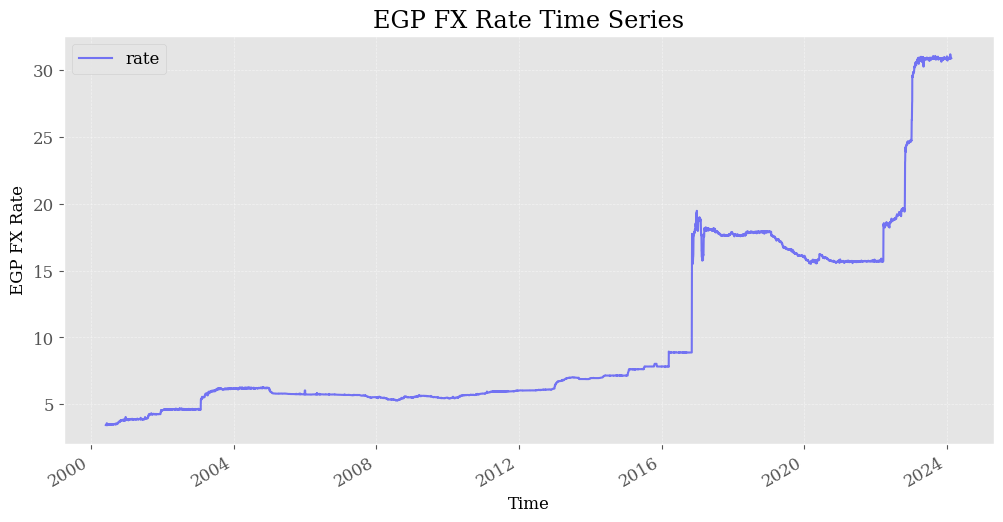

### HUF Foreign Exchange Rate Time Series
***
    

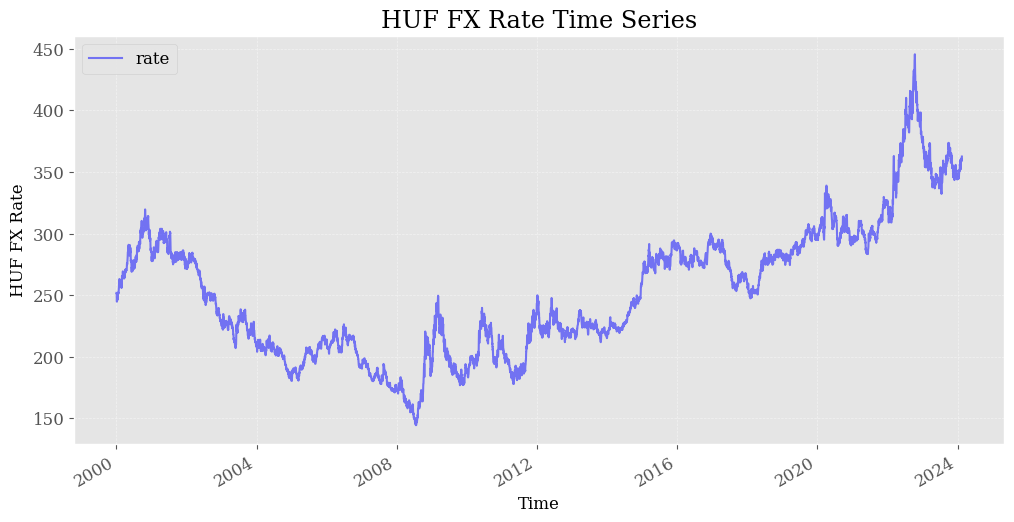

### CRC Foreign Exchange Rate Time Series
***
    

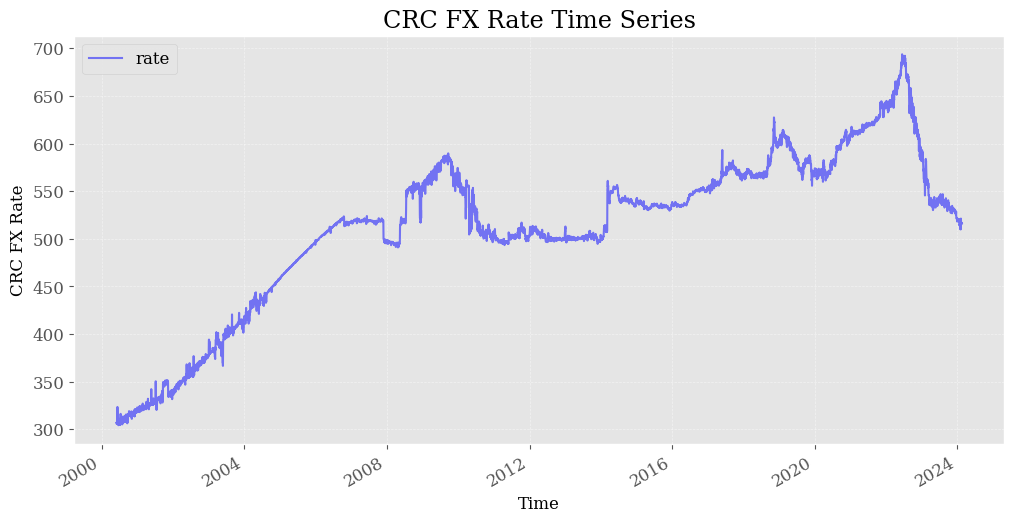

### RON Foreign Exchange Rate Time Series
***
    

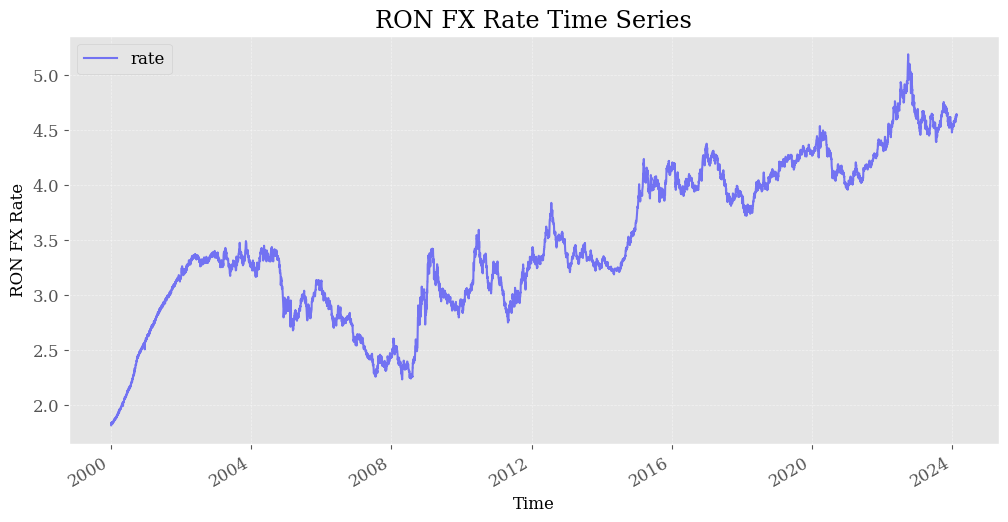

In [183]:
# interseted codes:
#   GBP
#   EGP
#   HUF
#   CRC
#   RON 
intersted_country_codes = ['GBP', 'EGP', 'HUF', 'CRC', 'RON']
for country_code in intersted_country_codes:
    display(Markdown(f"""### {country_code} Foreign Exchange Rate Time Series\n***
    """))
    fx_rates_table[fx_rates_table['code'] == country_code].set_index('date').sort_index().plot.line(xlabel='Time', ylabel=f'{country_code} FX Rate', title=f'{country_code} FX Rate Time Series', color='blue', alpha=0.5, figsize=(12,6))
    plt.show()

#### FX Rate Correlation
***

In [189]:
pd.concat([pd.Series(fx_rates_table[fx_rates_table['code'] == country_code].set_index('date').sort_index()['rate'], name=f'{country_code}_rate') for country_code in intersted_country_codes], axis=1).dropna()

GBP_rate  EGP_rate  HUF_rate  CRC_rate  RON_rate
date                                                        
2000-05-31    0.6683    3.4459  278.4335  306.7935    2.0706
2000-06-01    0.6699    3.4428  277.8769  306.6238    2.0636
2000-06-02    0.6654    3.4382  277.4081  305.8044    2.0649
2000-06-05    0.6597    3.4525  275.5295  308.0038    2.0804
2000-06-06    0.6570    3.4520  272.7204  307.1987    2.0896
...              ...       ...       ...       ...       ...
2024-02-11    0.7918   30.9000  358.8200  516.2547    4.6141
2024-02-12    0.7918   30.8699  358.6563  515.6828    4.6126
2024-02-13    0.7926   30.9003  359.6360  516.8641    4.6214
2024-02-14    0.7933   30.9003  361.3230  516.7026    4.6441
2024-02-15    0.7958   30.9050  362.4521  516.2884    4.6380

[7828 rows x 5 columns]

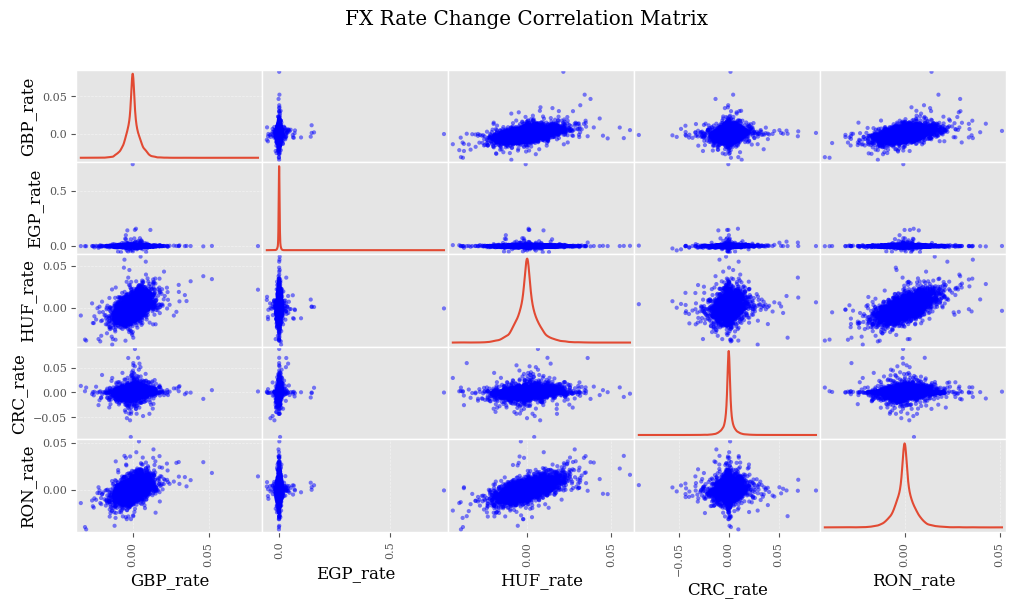

In [194]:
# interseted codes:
#   GBP
#   EGP
#   HUF
#   CRC
#   RON 
intersted_country_codes = ['GBP', 'EGP', 'HUF', 'CRC', 'RON']

scatter_matrix(
    pd.concat([pd.Series(fx_rates_table[fx_rates_table['code'] == country_code].set_index('date').sort_index()['rate'].pct_change(), name=f'{country_code}_rate') for country_code in intersted_country_codes], axis=1).dropna(),
    diagonal='kde', color='b', figsize=(12,6)
)
plt.suptitle('FX Rate Change Correlation Matrix')
plt.show()

### 3. Deeper Dive into FX Rate Correlations
***

## Regression Egp Fx Rate on Gbp Fx Rate
***
        

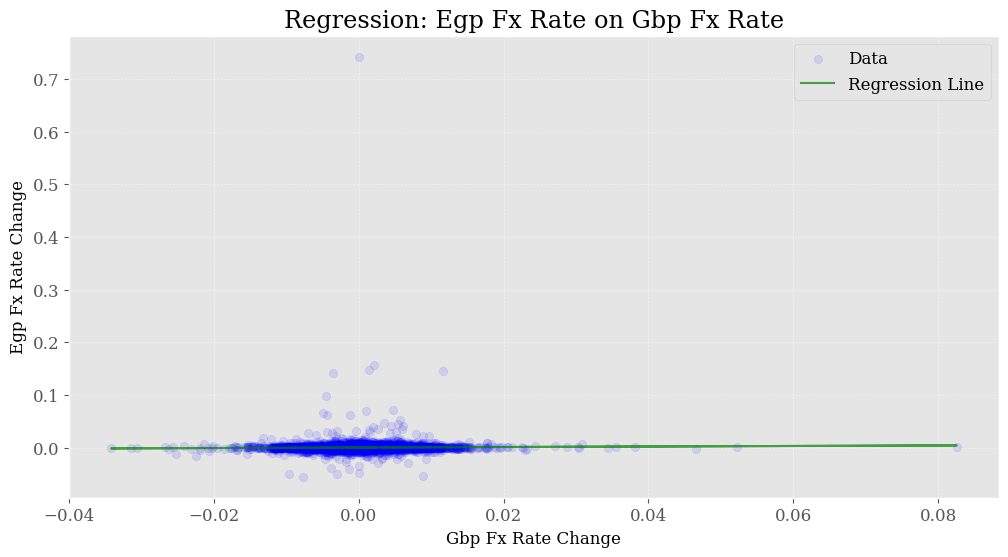

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               EGP_rate   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              4.620
Date:                Thu, 15 Feb 2024   Prob (F-statistic):                      0.0316
Time:                        19:01:10   Log-Likelihood:                          24976.
No. Observations:                7827   AIC:                                 -4.995e+04
Df Residuals:                    7826   BIC:                                 -4.994e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GBP_rate       0.0491      0.023      2.149      0.032       0.004       0.094
==============================================================================
Omnibus:                    25564.388   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       5178834116.012
Skew:                          55.022   Prob(JB):                         0.00
Kurtosis:                    3986.440   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression Huf Fx Rate on Gbp Fx Rate
***
        

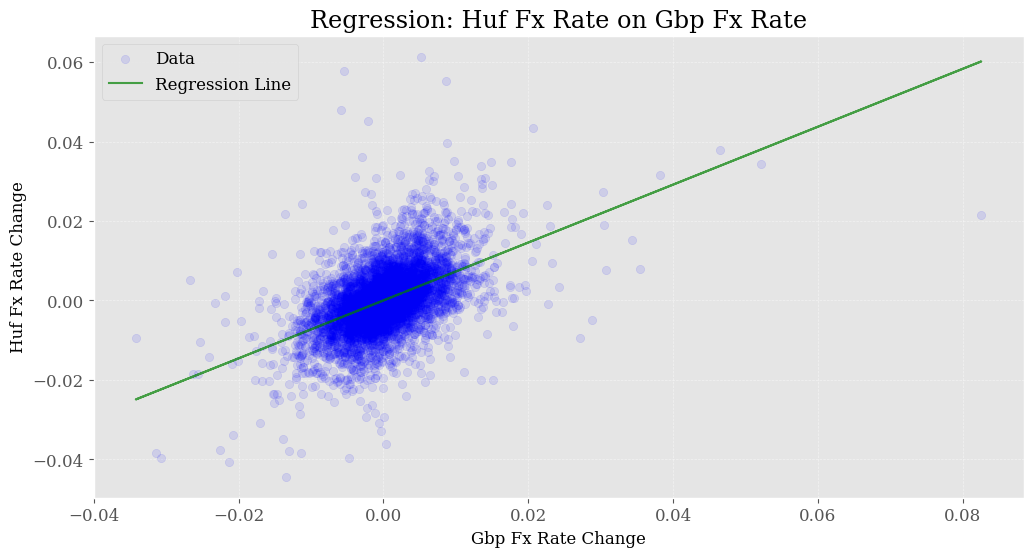

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               HUF_rate   R-squared (uncentered):                   0.246
Model:                            OLS   Adj. R-squared (uncentered):              0.246
Method:                 Least Squares   F-statistic:                              2560.
Date:                Thu, 15 Feb 2024   Prob (F-statistic):                        0.00
Time:                        19:01:10   Log-Likelihood:                          28592.
No. Observations:                7827   AIC:                                 -5.718e+04
Df Residuals:                    7826   BIC:                                 -5.717e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GBP_rate       0.7287      0.014     50.597      0.000       0.701       0.757
==============================================================================
Omnibus:                     1329.732   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15082.827
Skew:                           0.466   Prob(JB):                         0.00
Kurtosis:                       9.737   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression Crc Fx Rate on Gbp Fx Rate
***
        

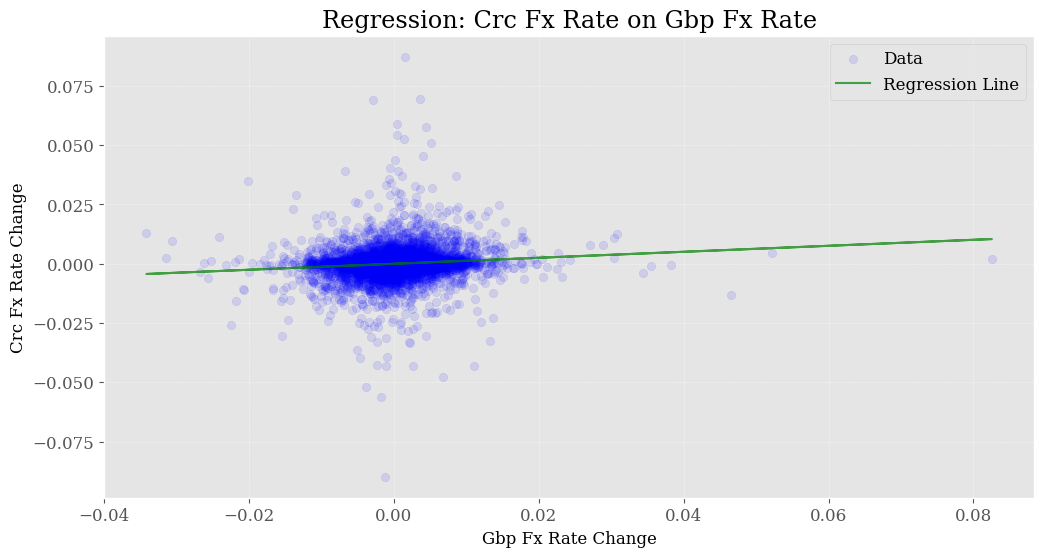

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               CRC_rate   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):              0.011
Method:                 Least Squares   F-statistic:                              91.28
Date:                Thu, 15 Feb 2024   Prob (F-statistic):                    1.63e-21
Time:                        19:01:10   Log-Likelihood:                          29265.
No. Observations:                7827   AIC:                                 -5.853e+04
Df Residuals:                    7826   BIC:                                 -5.852e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GBP_rate       0.1263      0.013      9.554      0.000       0.100       0.152
==============================================================================
Omnibus:                     2906.201   Durbin-Watson:                   2.557
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           422103.350
Skew:                           0.709   Prob(JB):                         0.00
Kurtosis:                      38.948   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression Ron Fx Rate on Gbp Fx Rate
***
        

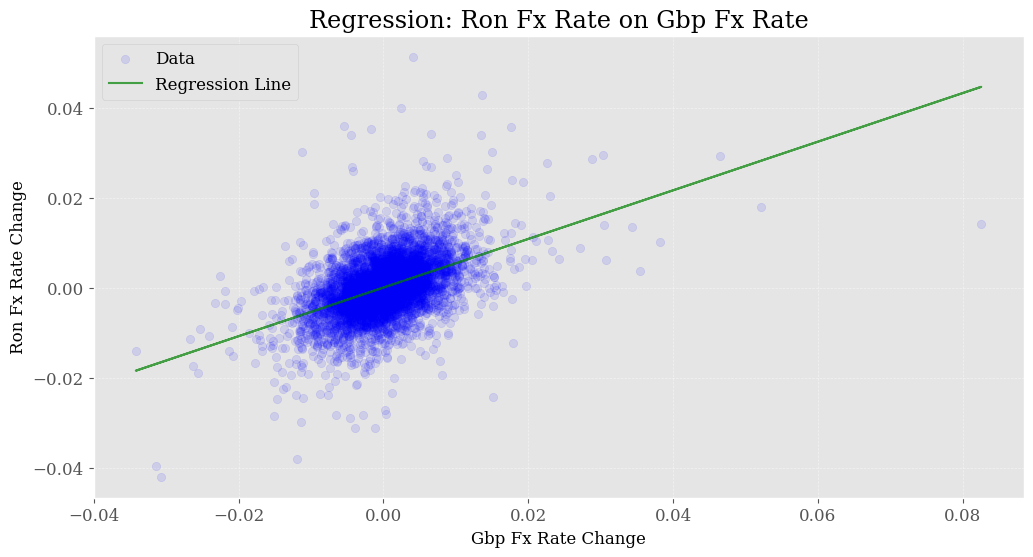

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               RON_rate   R-squared (uncentered):                   0.215
Model:                            OLS   Adj. R-squared (uncentered):              0.215
Method:                 Least Squares   F-statistic:                              2147.
Date:                Thu, 15 Feb 2024   Prob (F-statistic):                        0.00
Time:                        19:01:10   Log-Likelihood:                          30245.
No. Observations:                7827   AIC:                                 -6.049e+04
Df Residuals:                    7826   BIC:                                 -6.048e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GBP_rate       0.5402      0.012     46.331      0.000       0.517       0.563
==============================================================================
Omnibus:                     1258.011   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15374.472
Skew:                           0.379   Prob(JB):                         0.00
Kurtosis:                       9.824   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression Huf Fx Rate on Egp Fx Rate
***
        

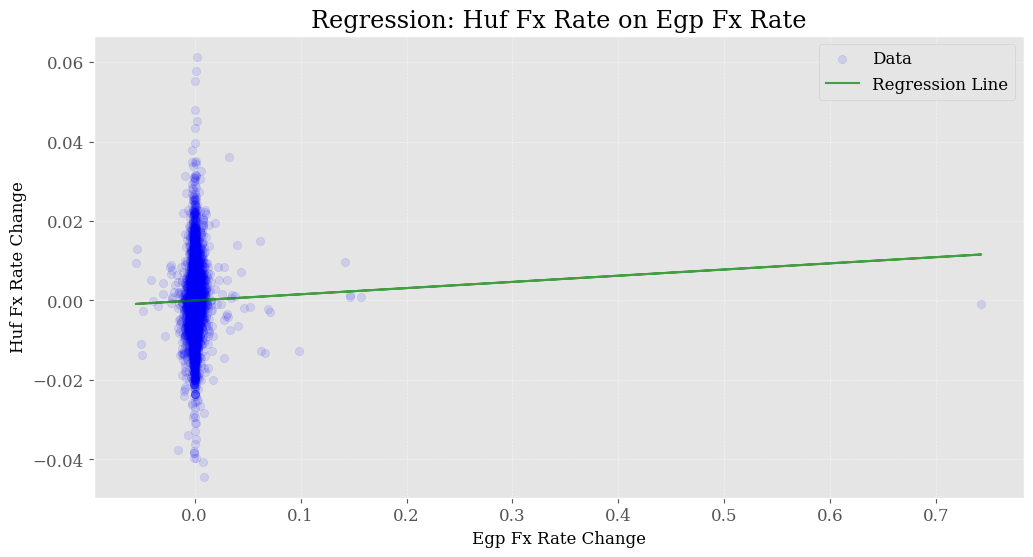

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               HUF_rate   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              3.613
Date:                Thu, 15 Feb 2024   Prob (F-statistic):                      0.0574
Time:                        19:01:10   Log-Likelihood:                          27486.
No. Observations:                7827   AIC:                                 -5.497e+04
Df Residuals:                    7826   BIC:                                 -5.496e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
EGP_rate       0.0156      0.008      1.901      0.057      -0.000       0.032
==============================================================================
Omnibus:                     1108.533   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9769.602
Skew:                           0.395   Prob(JB):                         0.00
Kurtosis:                       8.416   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression Crc Fx Rate on Egp Fx Rate
***
        

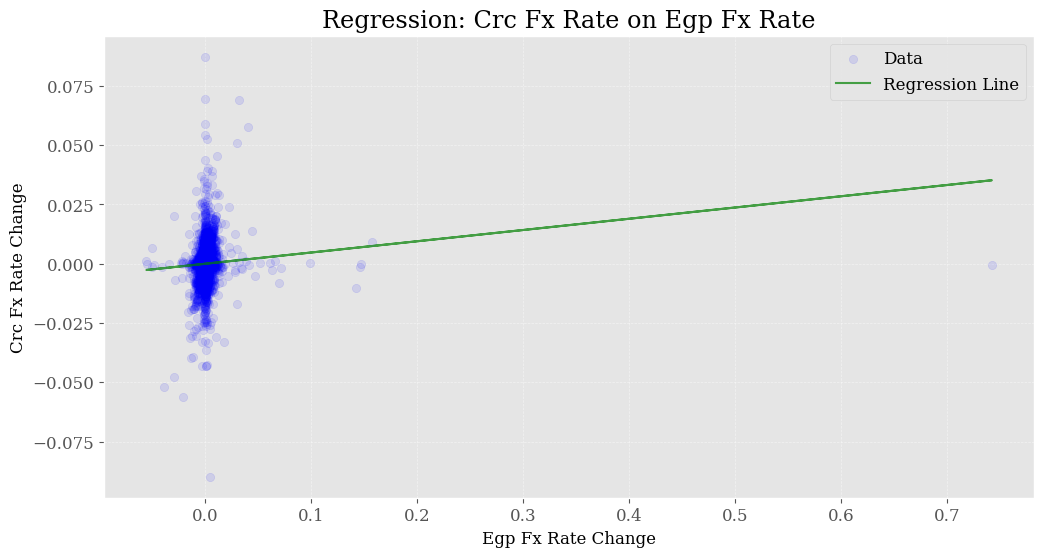

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               CRC_rate   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              52.47
Date:                Thu, 15 Feb 2024   Prob (F-statistic):                    4.79e-13
Time:                        19:01:10   Log-Likelihood:                          29245.
No. Observations:                7827   AIC:                                 -5.849e+04
Df Residuals:                    7826   BIC:                                 -5.848e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
EGP_rate       0.0474      0.007      7.243      0.000       0.035       0.060
==============================================================================
Omnibus:                     2834.307   Durbin-Watson:                   2.556
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           405164.934
Skew:                           0.664   Prob(JB):                         0.00
Kurtosis:                      38.222   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression Ron Fx Rate on Egp Fx Rate
***
        

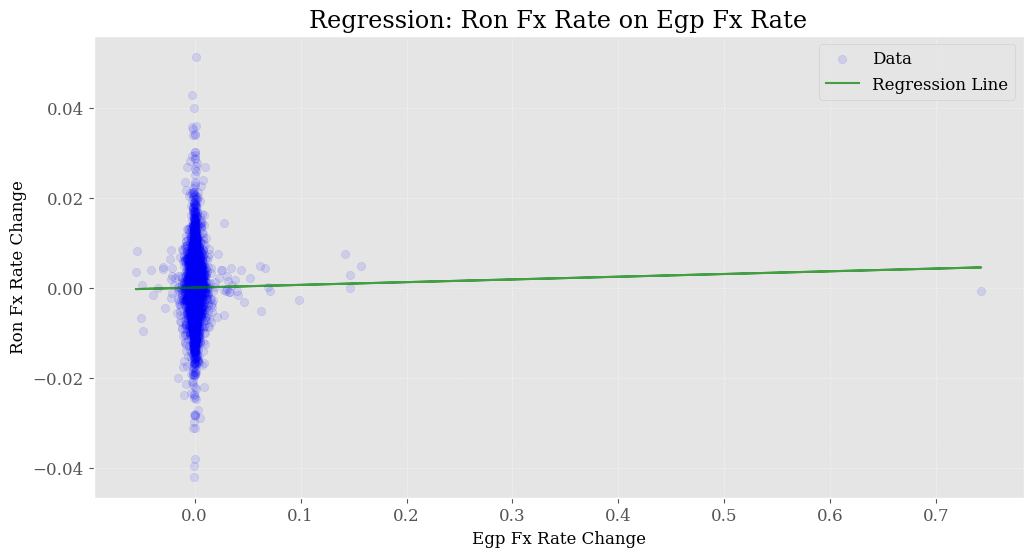

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               RON_rate   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                             0.8613
Date:                Thu, 15 Feb 2024   Prob (F-statistic):                       0.353
Time:                        19:01:11   Log-Likelihood:                          29297.
No. Observations:                7827   AIC:                                 -5.859e+04
Df Residuals:                    7826   BIC:                                 -5.859e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
EGP_rate       0.0060      0.007      0.928      0.353      -0.007       0.019
==============================================================================
Omnibus:                     1130.373   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12583.297
Skew:                           0.309   Prob(JB):                         0.00
Kurtosis:                       9.181   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression Crc Fx Rate on Huf Fx Rate
***
        

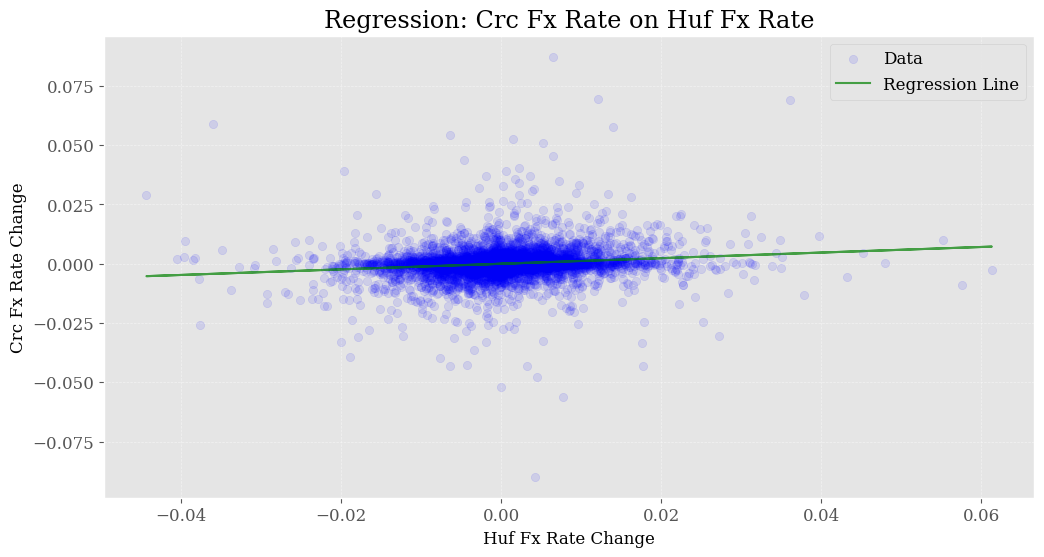

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               CRC_rate   R-squared (uncentered):                   0.022
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              173.3
Date:                Thu, 15 Feb 2024   Prob (F-statistic):                    3.62e-39
Time:                        19:01:11   Log-Likelihood:                          29305.
No. Observations:                7827   AIC:                                 -5.861e+04
Df Residuals:                    7826   BIC:                                 -5.860e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
HUF_rate       0.1179      0.009     13.165      0.000       0.100       0.135
==============================================================================
Omnibus:                     2871.023   Durbin-Watson:                   2.544
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           431690.620
Skew:                           0.674   Prob(JB):                         0.00
Kurtosis:                      39.358   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression Ron Fx Rate on Huf Fx Rate
***
        

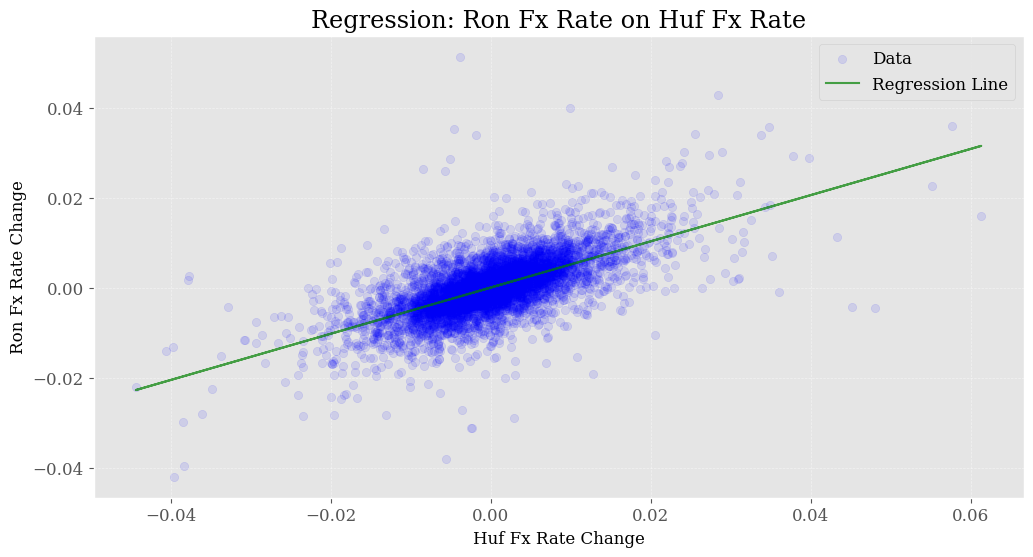

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               RON_rate   R-squared (uncentered):                   0.419
Model:                            OLS   Adj. R-squared (uncentered):              0.419
Method:                 Least Squares   F-statistic:                              5636.
Date:                Thu, 15 Feb 2024   Prob (F-statistic):                        0.00
Time:                        19:01:11   Log-Likelihood:                          31419.
No. Observations:                7827   AIC:                                 -6.284e+04
Df Residuals:                    7826   BIC:                                 -6.283e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
HUF_rate       0.5133      0.007     75.072      0.000       0.500       0.527
==============================================================================
Omnibus:                     1467.788   Durbin-Watson:                   2.141
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31208.273
Skew:                           0.305   Prob(JB):                         0.00
Kurtosis:                      12.763   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression Ron Fx Rate on Crc Fx Rate
***
        

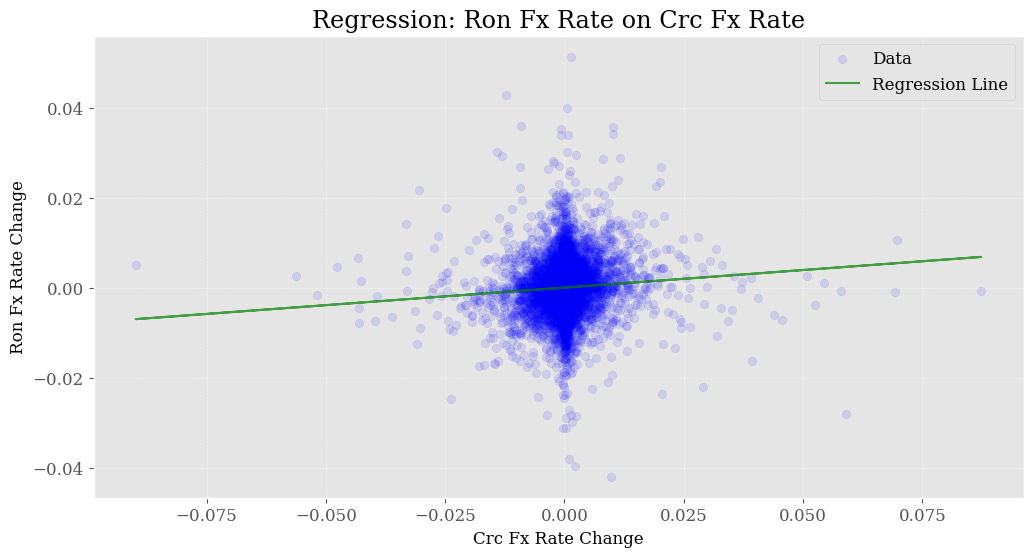

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               RON_rate   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              48.91
Date:                Thu, 15 Feb 2024   Prob (F-statistic):                    2.90e-12
Time:                        19:01:11   Log-Likelihood:                          29321.
No. Observations:                7827   AIC:                                 -5.864e+04
Df Residuals:                    7826   BIC:                                 -5.863e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRC_rate       0.0780      0.011      6.994      0.000       0.056       0.100
==============================================================================
Omnibus:                     1144.335   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13434.147
Skew:                           0.296   Prob(JB):                         0.00
Kurtosis:                       9.391   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [324]:
df = pd.concat([pd.Series(fx_rates_table[fx_rates_table['code'] == country_code].set_index('date').sort_index()['rate'].pct_change(), name=f'{country_code}_rate') for country_code in intersted_country_codes], axis=1).dropna()
variables = df.columns

# Perform pairwise regressions
for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        x = df[variables[i]]
        y = df[variables[j]]
        # Fit the linear regression model
        model = sm.OLS(y, x).fit()

        display(Markdown(f"""## Regression {variables[j].replace("_", " FX ").title()} on {variables[i].replace("_", " FX ").title()}\n***
        """))
        
        plt.figure(figsize=(12,6))
        # Plot the data points
        plt.scatter(x, y, label='Data', color='blue', alpha=0.1)
        
        # Plot the regression line
        plt.plot(x, model.predict(x), color='green', label='Regression Line', alpha=0.7)
        
        # Add labels and legend
        plt.xlabel(f'{variables[i].replace("_", " FX ").title()} Change')
        plt.ylabel(f'{variables[j].replace("_", " FX ").title()} Change')
        plt.legend()
        
        # Add title
        plt.title(f'Regression: {variables[j].replace("_", " FX ").title()} on {variables[i].replace("_", " FX ").title()}')
        
        # Show plot
        plt.show()
        display(model.summary())
        print("\n" * 7)

## IV. Trading Strategy
***

In [343]:
CAPITAL = 2_000_000
NOTIONAL = 10_000_000

<Figure size 1200x600 with 0 Axes>

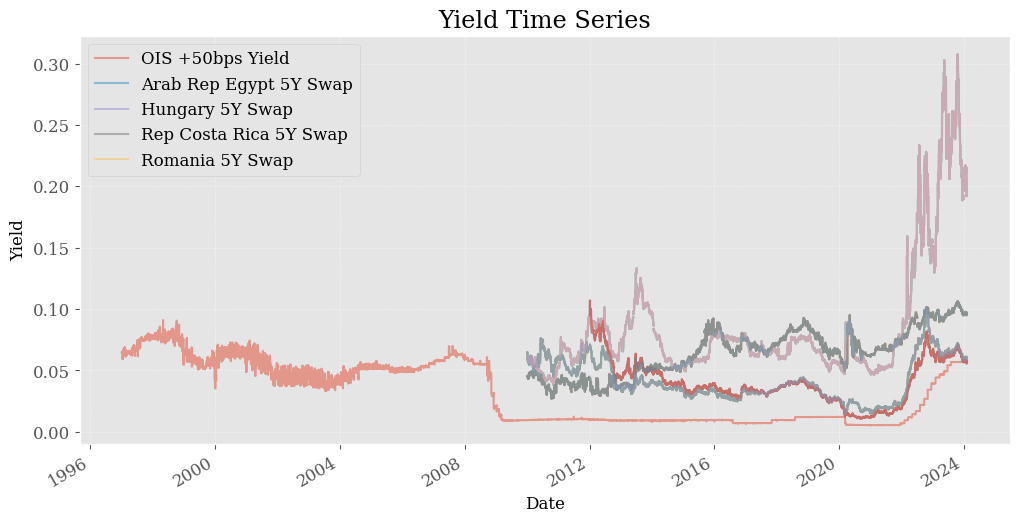

In [344]:
PlotDynamics.plot_multiple_ts(
    [
        ois_table['ois_50bps'],
    ] + [
        yield_curve_table.loc[(country, '5Y'), ['date', 'yield']].reset_index().set_index('date')['yield'] for country in sorted(yield_curve_table.index.get_level_values('shortname').unique())
    ],
    [
        'OIS +50bps Yield',
    ] + [
        f'{country} 5Y Swap' for country in sorted(yield_curve_table.index.get_level_values('shortname').unique())
    ],
    ylabel='Yield',
    xlabel='Date',
    title='Yield Time Series',
    alphas=[0.5] * 5
)

### 1. Arab Rep Egypt 5Y Carry Trade
***

In [366]:
country_code = 'EGP'
country_shortname = 'Arab Rep Egypt'
current_tenor = '5Y'

are_start_date = yield_curve_table.loc[(f'{country_shortname}', f'{current_tenor}'), 'date'].min()
are_end_date = yield_curve_table.loc[(f'{country_shortname}', f'{current_tenor}'), 'date'].max()
egp_5y_ois_df = pd.merge(
    ois_table.reindex(pd.date_range(are_start_date, are_end_date, freq='D')),
    yield_curve_table.loc[(f'{country_shortname}', f'{current_tenor}'), ['date', 'yield']].reset_index().set_index('date')['yield'],
    how='left',
    left_index=True, right_index=True
).ffill().rename(columns={'yield': f'{country_code}_yield'})

egp_5y_ois_df = Compute.swap_signal(egp_5y_ois_df, 'ois_50bps', f'{country_code}_yield')

if 'GBP_rate' not in egp_5y_ois_df.columns:
    egp_5y_ois_df = egp_5y_ois_df.merge(
        fx_rates_table[fx_rates_table['code'] == 'GBP'][['date', 'rate']].set_index('date').reindex(pd.date_range(egp_5y_ois_df.index.min(), egp_5y_ois_df.index.max(), freq='D')).ffill(),
        how='left', 
        left_index=True, right_index=True
    ).rename(columns={'rate': 'GBP_rate'})
if f'{country_code}_rate' not in egp_5y_ois_df.columns:
    egp_5y_ois_df = egp_5y_ois_df.merge(
        fx_rates_table[fx_rates_table['code'] == f'{country_code}'][['date', 'rate']].set_index('date').reindex(pd.date_range(egp_5y_ois_df.index.min(), egp_5y_ois_df.index.max(), freq='D')).ffill(),
        how='left', 
        left_index=True, right_index=True
    ).rename(columns={'rate': f'{country_code}_rate'})


#### EGP and OIS +50bps Spread Time Series
***

<Figure size 1200x600 with 0 Axes>

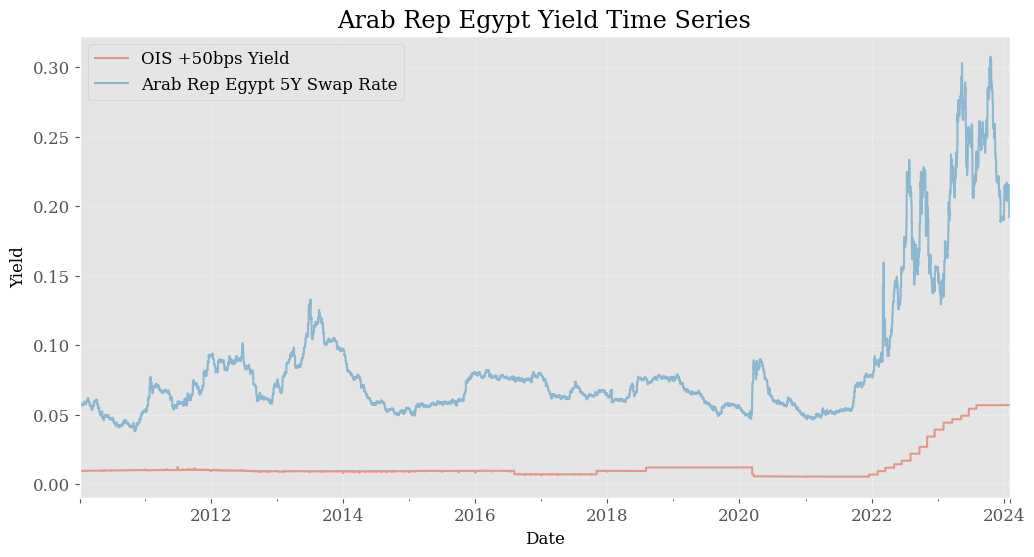

In [367]:
PlotDynamics.plot_multiple_ts(
    [
        egp_5y_ois_df['ois_50bps'],
        egp_5y_ois_df[f'{country_code}_yield']
    ],
    [
        'OIS +50bps Yield',
        f'{country_shortname} {current_tenor} Swap Rate'
    ],
    ylabel='Yield',
    xlabel='Date',
    title=f'{country_shortname} Yield Time Series',
    alphas=[0.5] * 5
)

#### EGP Carry Trade Time Series Performance
***

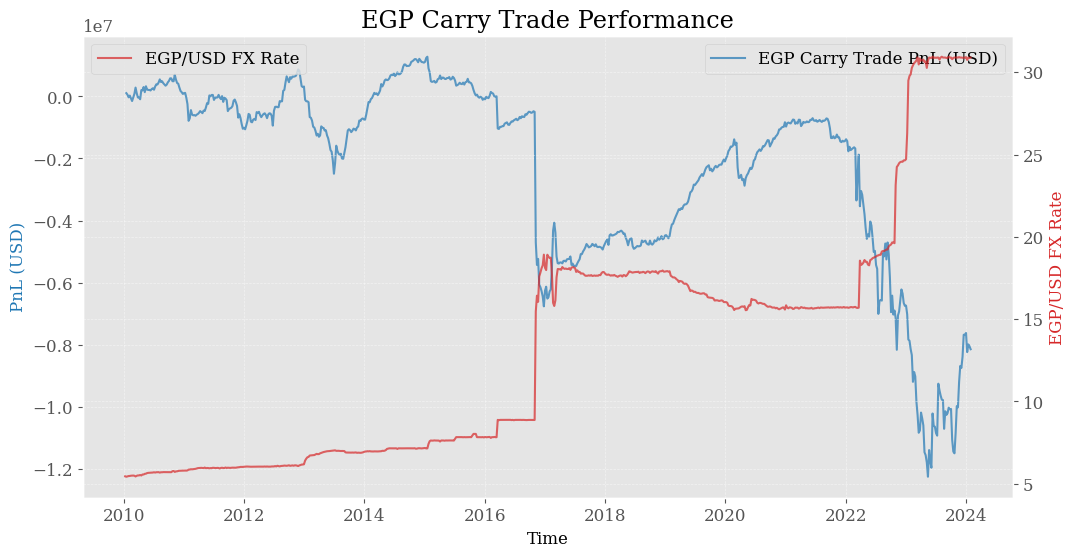

In [368]:
egp_5y_ois_df = Compute.carry_trade(
    egp_5y_ois_df,
    'ois_50bps',
    f'{country_code}_yield',
    'signal',
    'GBP_rate',
    f'{country_code}_rate',
    NOTIONAL,
    CAPITAL
)

PlotDynamics.plot_dual_axis_timeseries(
    egp_5y_ois_df.index, 
    [egp_5y_ois_df['USD_net_PnL']], 
    [egp_5y_ois_df[f'{country_code}_rate']],
    y1_series_names=[f'{country_code} Carry Trade PnL (USD)'],
    y2_series_names=[f'{country_code}/USD FX Rate'],
    y1label='PnL (USD)',
    y2label=f'{country_code}/USD FX Rate',
    title=f'{country_code} Carry Trade Performance',
    alpha=[0.7,0.7]
)
# plt.legend()
plt.show()

#### EGP Carry Trade Returns Analysis
***

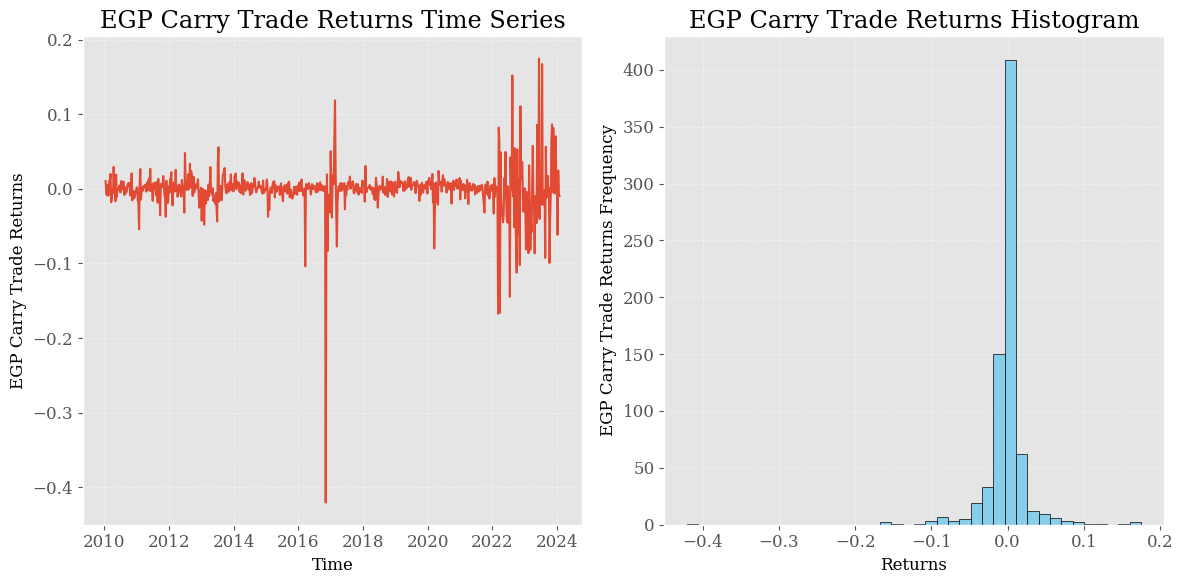

In [369]:
egp_5y_ois_df['returns'] = ((egp_5y_ois_df['USD_net_PnL_change'] + NOTIONAL) / NOTIONAL) - 1
PlotDynamics.plot_returns_ts_hist(
    egp_5y_ois_df['returns'],
    f'{country_code} Carry Trade',
    bins=40,
)

### 2. Hungary 5Y Carry Trade
***

In [372]:
country_code = 'HUF'
country_shortname = 'Hungary'
current_tenor = '5Y'

are_start_date = yield_curve_table.loc[(f'{country_shortname}', f'{current_tenor}'), 'date'].min()
are_end_date = yield_curve_table.loc[(f'{country_shortname}', f'{current_tenor}'), 'date'].max()
huf_5y_ois_df = pd.merge(
    ois_table.reindex(pd.date_range(are_start_date, are_end_date, freq='D')),
    yield_curve_table.loc[(f'{country_shortname}', f'{current_tenor}'), ['date', 'yield']].reset_index().set_index('date')['yield'],
    how='left',
    left_index=True, right_index=True
).ffill().rename(columns={'yield': f'{country_code}_yield'})

huf_5y_ois_df = Compute.swap_signal(huf_5y_ois_df, 'ois_50bps', f'{country_code}_yield')

if 'GBP_rate' not in huf_5y_ois_df.columns:
    huf_5y_ois_df = huf_5y_ois_df.merge(
        fx_rates_table[fx_rates_table['code'] == 'GBP'][['date', 'rate']].set_index('date').reindex(pd.date_range(huf_5y_ois_df.index.min(), huf_5y_ois_df.index.max(), freq='D')).ffill(),
        how='left', 
        left_index=True, right_index=True
    ).rename(columns={'rate': 'GBP_rate'})
if f'{country_code}_rate' not in huf_5y_ois_df.columns:
    huf_5y_ois_df = huf_5y_ois_df.merge(
        fx_rates_table[fx_rates_table['code'] == f'{country_code}'][['date', 'rate']].set_index('date').reindex(pd.date_range(huf_5y_ois_df.index.min(), huf_5y_ois_df.index.max(), freq='D')).ffill(),
        how='left', 
        left_index=True, right_index=True
    ).rename(columns={'rate': f'{country_code}_rate'})


#### HUF and OIS +50bps Spread Time Series
***

<Figure size 1200x600 with 0 Axes>

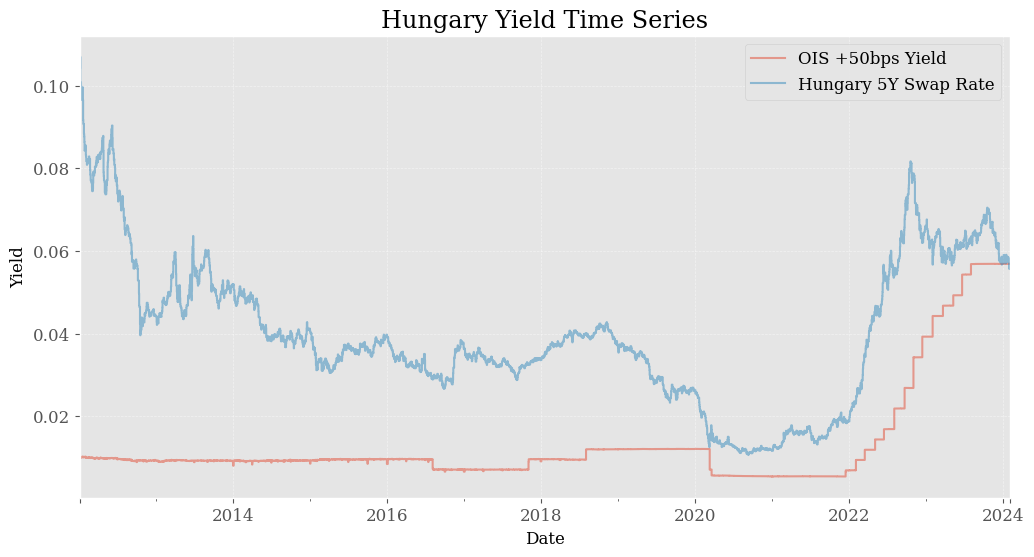

In [373]:
PlotDynamics.plot_multiple_ts(
    [
        huf_5y_ois_df['ois_50bps'],
        huf_5y_ois_df[f'{country_code}_yield']
    ],
    [
        'OIS +50bps Yield',
        f'{country_shortname} {current_tenor} Swap Rate'
    ],
    ylabel='Yield',
    xlabel='Date',
    title=f'{country_shortname} Yield Time Series',
    alphas=[0.5] * 5
)

#### HUF Carry Trade Time Series Performance
***

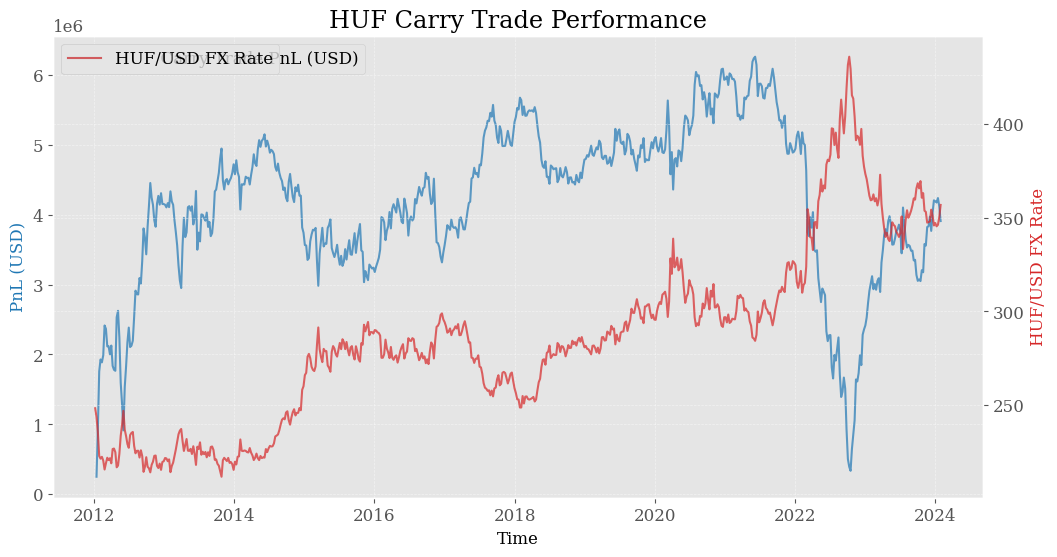

In [375]:
huf_5y_ois_df = Compute.carry_trade(
    huf_5y_ois_df,
    'ois_50bps',
    f'{country_code}_yield',
    'signal',
    'GBP_rate',
    f'{country_code}_rate',
    NOTIONAL,
    CAPITAL
)

PlotDynamics.plot_dual_axis_timeseries(
    huf_5y_ois_df.index, 
    [huf_5y_ois_df['USD_net_PnL']], 
    [huf_5y_ois_df[f'{country_code}_rate']],
    y1_series_names=[f'{country_code} Carry Trade PnL (USD)'],
    y2_series_names=[f'{country_code}/USD FX Rate'],
    y1label='PnL (USD)',
    y2label=f'{country_code}/USD FX Rate',
    title=f'{country_code} Carry Trade Performance',
    alpha=[0.7,0.7]
)
# plt.legend()
plt.show()

#### HUF Carry Trade Returns Analysis
***

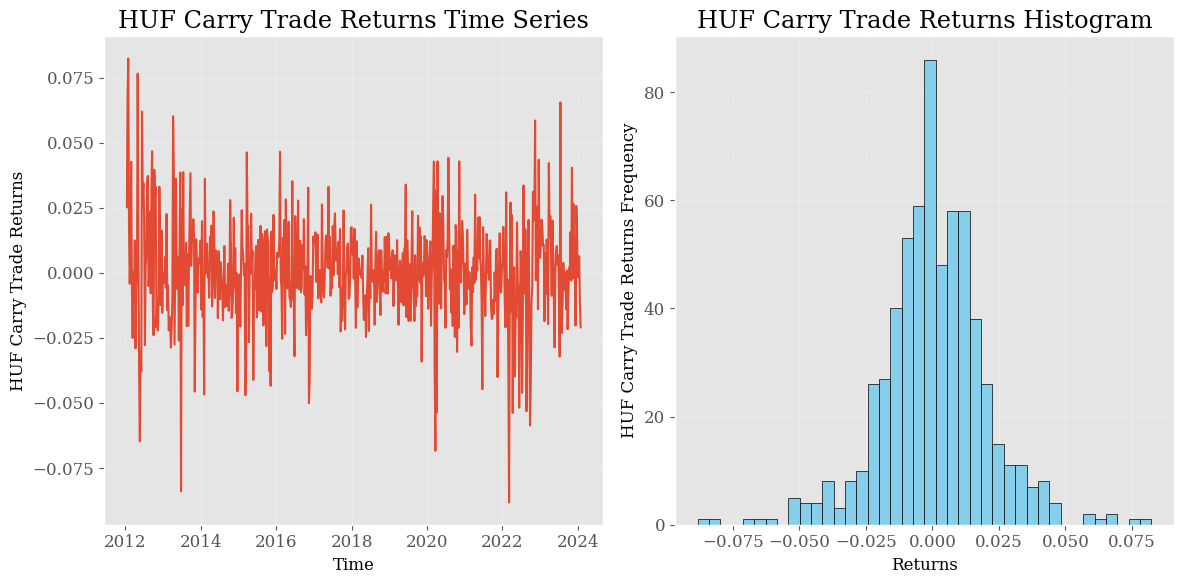

In [376]:
huf_5y_ois_df['returns'] = ((huf_5y_ois_df['USD_net_PnL_change'] + NOTIONAL) / NOTIONAL) - 1
PlotDynamics.plot_returns_ts_hist(
    huf_5y_ois_df['returns'],
    f'{country_code} Carry Trade',
    bins=40,
)

### 3. Costa Rica 5Y Carry Trade
***

In [379]:
country_code = 'CRC'
country_shortname = 'Rep Costa Rica'
current_tenor = '5Y'

are_start_date = yield_curve_table.loc[(f'{country_shortname}', f'{current_tenor}'), 'date'].min()
are_end_date = yield_curve_table.loc[(f'{country_shortname}', f'{current_tenor}'), 'date'].max()
crc_5y_ois_df = pd.merge(
    ois_table.reindex(pd.date_range(are_start_date, are_end_date, freq='D')),
    yield_curve_table.loc[(f'{country_shortname}', f'{current_tenor}'), ['date', 'yield']].reset_index().set_index('date')['yield'],
    how='left',
    left_index=True, right_index=True
).ffill().rename(columns={'yield': f'{country_code}_yield'})

crc_5y_ois_df = Compute.swap_signal(crc_5y_ois_df, 'ois_50bps', f'{country_code}_yield')

if 'GBP_rate' not in crc_5y_ois_df.columns:
    crc_5y_ois_df = crc_5y_ois_df.merge(
        fx_rates_table[fx_rates_table['code'] == 'GBP'][['date', 'rate']].set_index('date').reindex(pd.date_range(crc_5y_ois_df.index.min(), crc_5y_ois_df.index.max(), freq='D')).ffill(),
        how='left', 
        left_index=True, right_index=True
    ).rename(columns={'rate': 'GBP_rate'})
if f'{country_code}_rate' not in crc_5y_ois_df.columns:
    crc_5y_ois_df = crc_5y_ois_df.merge(
        fx_rates_table[fx_rates_table['code'] == f'{country_code}'][['date', 'rate']].set_index('date').reindex(pd.date_range(crc_5y_ois_df.index.min(), crc_5y_ois_df.index.max(), freq='D')).ffill(),
        how='left', 
        left_index=True, right_index=True
    ).rename(columns={'rate': f'{country_code}_rate'})


#### CRC and OIS +50bps Spread Time Series
***

<Figure size 1200x600 with 0 Axes>

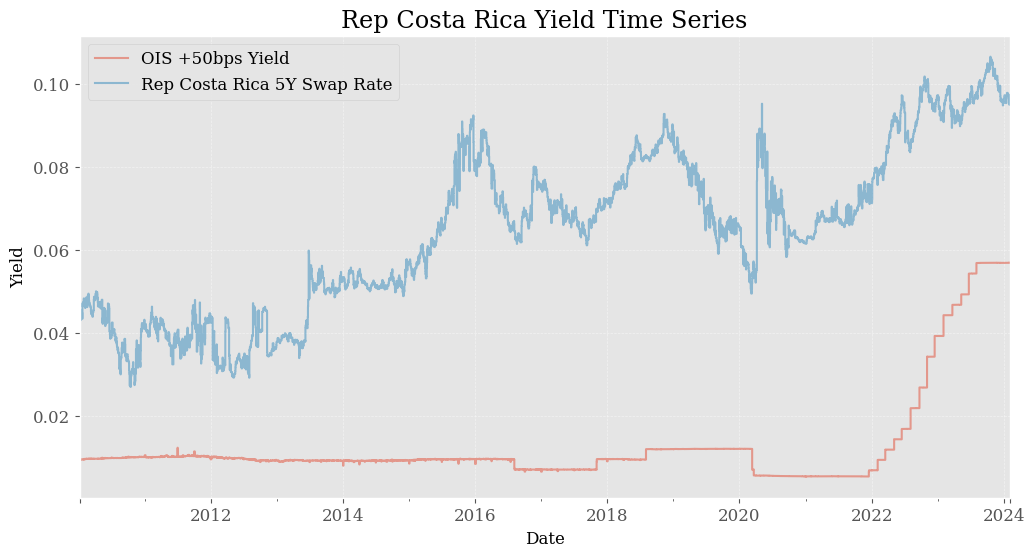

In [380]:
PlotDynamics.plot_multiple_ts(
    [
        crc_5y_ois_df['ois_50bps'],
        crc_5y_ois_df[f'{country_code}_yield']
    ],
    [
        'OIS +50bps Yield',
        f'{country_shortname} {current_tenor} Swap Rate'
    ],
    ylabel='Yield',
    xlabel='Date',
    title=f'{country_shortname} Yield Time Series',
    alphas=[0.5] * 5
)

#### CRC Carry Trade Time Series Performance
***

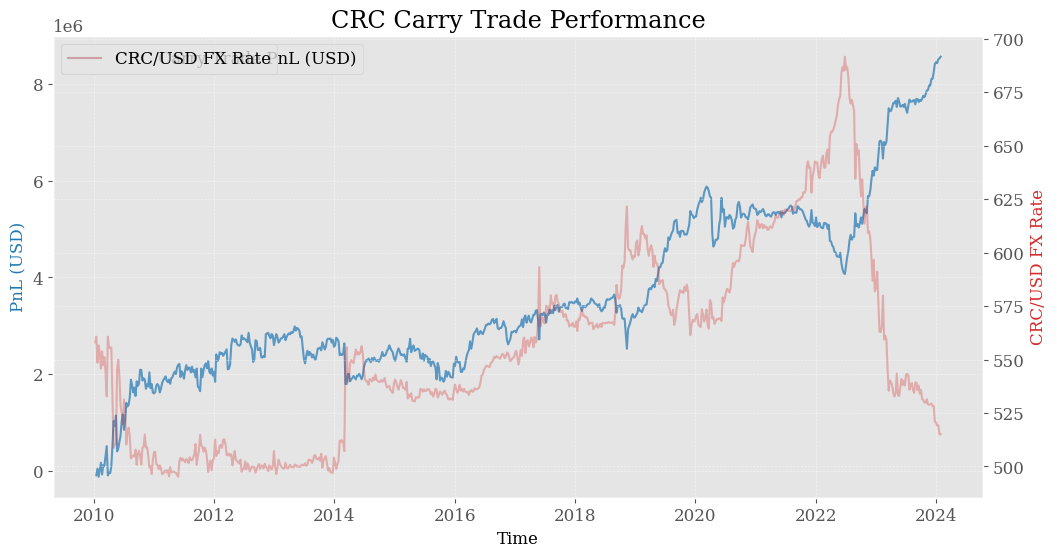

In [381]:
crc_5y_ois_df = Compute.carry_trade(
    crc_5y_ois_df,
    'ois_50bps',
    f'{country_code}_yield',
    'signal',
    'GBP_rate',
    f'{country_code}_rate',
    NOTIONAL,
    CAPITAL
)

PlotDynamics.plot_dual_axis_timeseries(
    crc_5y_ois_df.index, 
    [crc_5y_ois_df['USD_net_PnL']], 
    [crc_5y_ois_df[f'{country_code}_rate']],
    y1_series_names=[f'{country_code} Carry Trade PnL (USD)'],
    y2_series_names=[f'{country_code}/USD FX Rate'],
    y1label='PnL (USD)',
    y2label=f'{country_code}/USD FX Rate',
    title=f'{country_code} Carry Trade Performance',
    alpha=[0.7,0.3]
)
# plt.legend()
plt.show()

#### CRC Carry Trade Returns Analysis
***

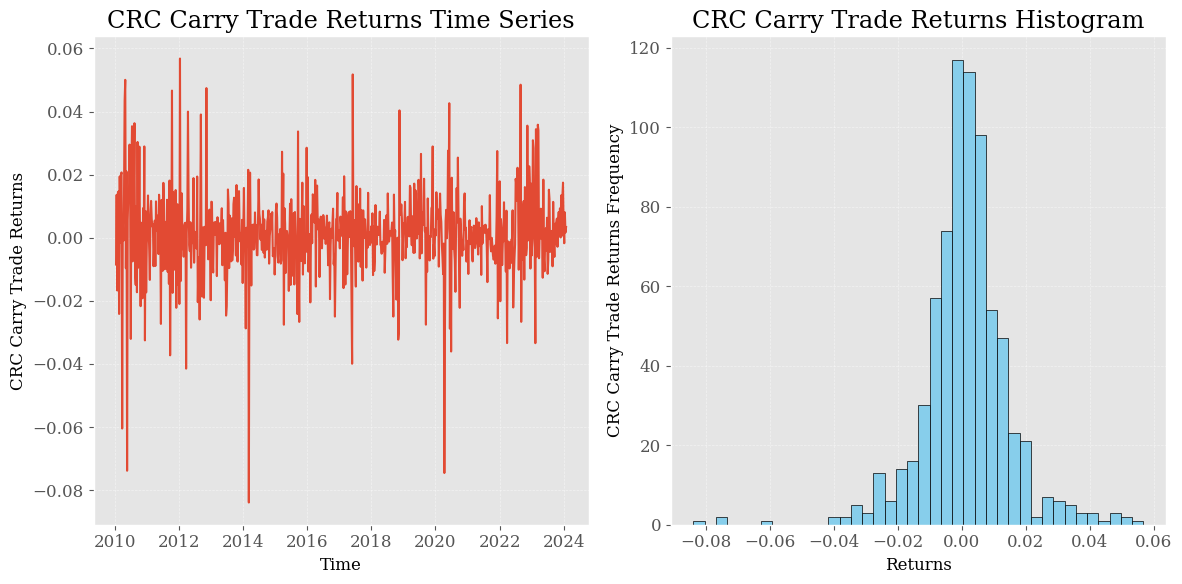

In [382]:
crc_5y_ois_df['returns'] = ((crc_5y_ois_df['USD_net_PnL_change'] + NOTIONAL) / NOTIONAL) - 1
PlotDynamics.plot_returns_ts_hist(
    crc_5y_ois_df['returns'],
    f'{country_code} Carry Trade',
    bins=40,
)

### 4. Romania 5Y Carry Trade
***

In [383]:
country_code = 'RON'
country_shortname = 'Romania'
current_tenor = '5Y'

are_start_date = yield_curve_table.loc[(f'{country_shortname}', f'{current_tenor}'), 'date'].min()
are_end_date = yield_curve_table.loc[(f'{country_shortname}', f'{current_tenor}'), 'date'].max()
ron_5y_ois_df = pd.merge(
    ois_table.reindex(pd.date_range(are_start_date, are_end_date, freq='D')),
    yield_curve_table.loc[(f'{country_shortname}', f'{current_tenor}'), ['date', 'yield']].reset_index().set_index('date')['yield'],
    how='left',
    left_index=True, right_index=True
).ffill().rename(columns={'yield': f'{country_code}_yield'})

ron_5y_ois_df = Compute.swap_signal(ron_5y_ois_df, 'ois_50bps', f'{country_code}_yield')

if 'GBP_rate' not in ron_5y_ois_df.columns:
    ron_5y_ois_df = ron_5y_ois_df.merge(
        fx_rates_table[fx_rates_table['code'] == 'GBP'][['date', 'rate']].set_index('date').reindex(pd.date_range(ron_5y_ois_df.index.min(), ron_5y_ois_df.index.max(), freq='D')).ffill(),
        how='left', 
        left_index=True, right_index=True
    ).rename(columns={'rate': 'GBP_rate'})
if f'{country_code}_rate' not in ron_5y_ois_df.columns:
    ron_5y_ois_df = ron_5y_ois_df.merge(
        fx_rates_table[fx_rates_table['code'] == f'{country_code}'][['date', 'rate']].set_index('date').reindex(pd.date_range(ron_5y_ois_df.index.min(), ron_5y_ois_df.index.max(), freq='D')).ffill(),
        how='left', 
        left_index=True, right_index=True
    ).rename(columns={'rate': f'{country_code}_rate'})


#### RON and OIS +50bps Spread Time Series
***

<Figure size 1200x600 with 0 Axes>

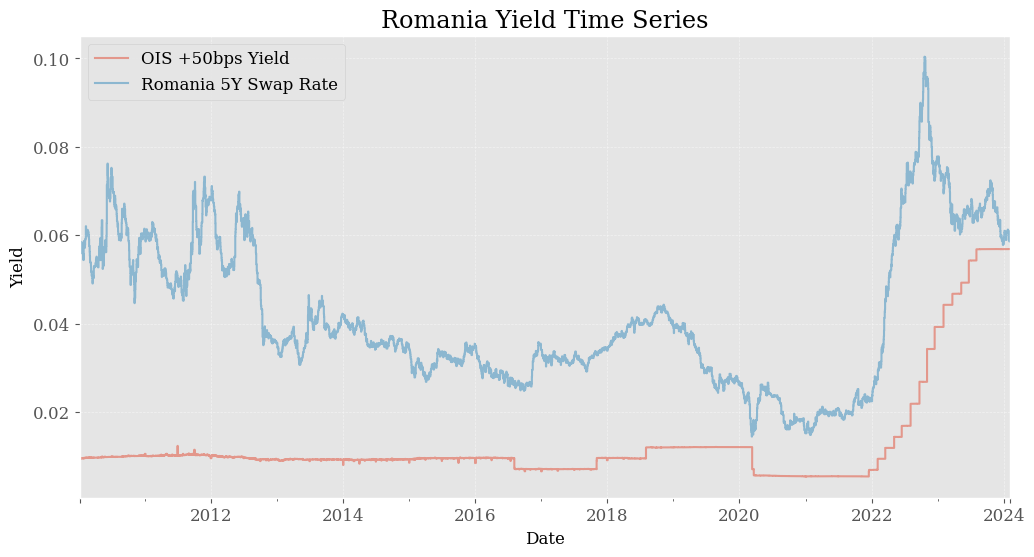

In [384]:
PlotDynamics.plot_multiple_ts(
    [
        ron_5y_ois_df['ois_50bps'],
        ron_5y_ois_df[f'{country_code}_yield']
    ],
    [
        'OIS +50bps Yield',
        f'{country_shortname} {current_tenor} Swap Rate'
    ],
    ylabel='Yield',
    xlabel='Date',
    title=f'{country_shortname} Yield Time Series',
    alphas=[0.5] * 5
)

#### RON Carry Trade Time Series Performance
***

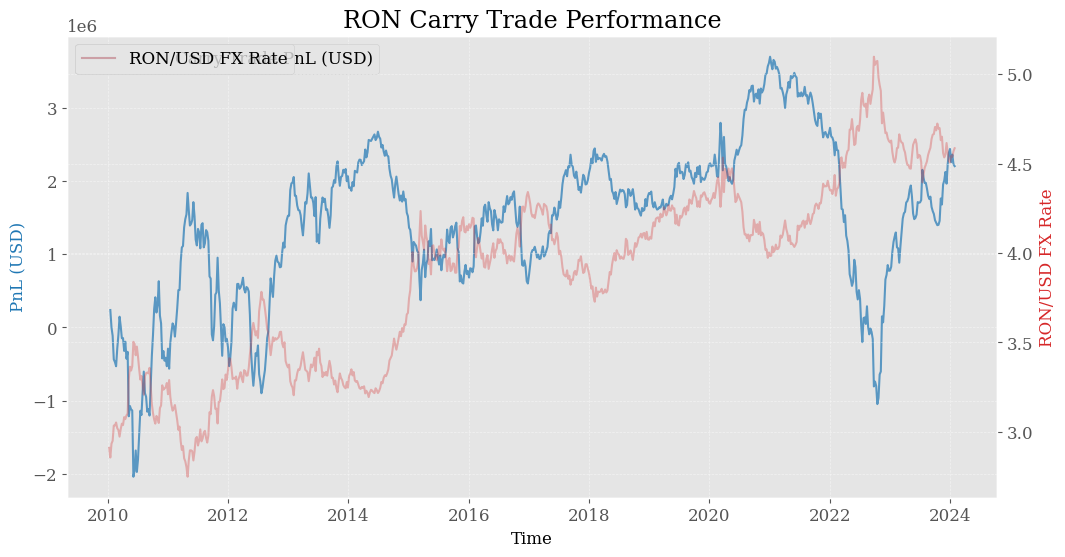

In [385]:
ron_5y_ois_df = Compute.carry_trade(
    ron_5y_ois_df,
    'ois_50bps',
    f'{country_code}_yield',
    'signal',
    'GBP_rate',
    f'{country_code}_rate',
    NOTIONAL,
    CAPITAL
)

PlotDynamics.plot_dual_axis_timeseries(
    ron_5y_ois_df.index, 
    [ron_5y_ois_df['USD_net_PnL']], 
    [ron_5y_ois_df[f'{country_code}_rate']],
    y1_series_names=[f'{country_code} Carry Trade PnL (USD)'],
    y2_series_names=[f'{country_code}/USD FX Rate'],
    y1label='PnL (USD)',
    y2label=f'{country_code}/USD FX Rate',
    title=f'{country_code} Carry Trade Performance',
    alpha=[0.7,0.3]
)
# plt.legend()
plt.show()

#### RON Carry Trade Returns Analysis
***

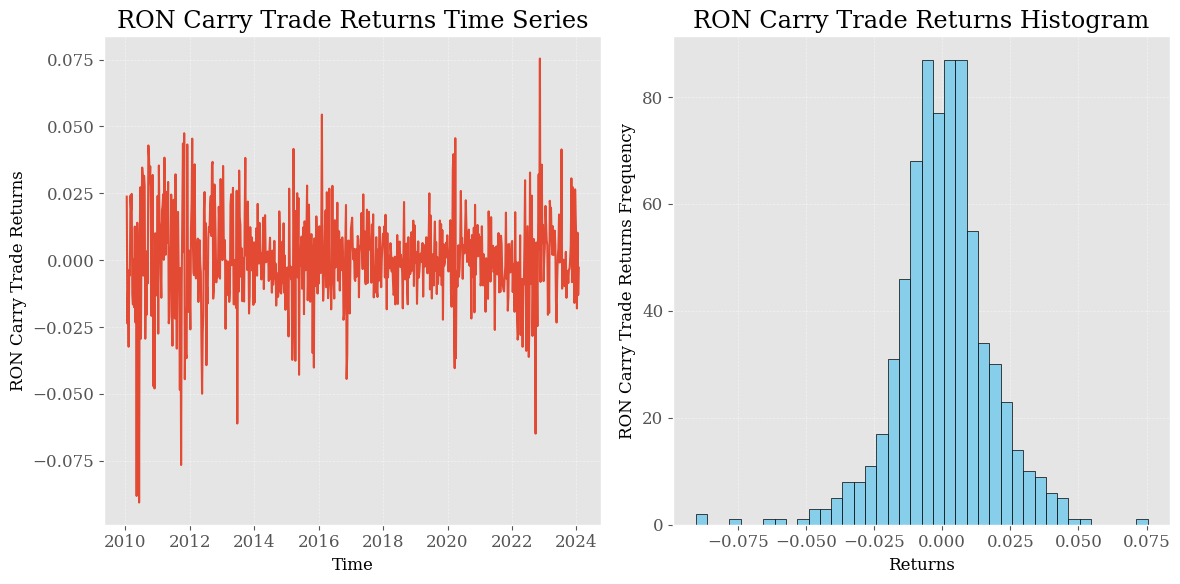

In [386]:
ron_5y_ois_df['returns'] = ((ron_5y_ois_df['USD_net_PnL_change'] + NOTIONAL) / NOTIONAL) - 1
PlotDynamics.plot_returns_ts_hist(
    ron_5y_ois_df['returns'],
    f'{country_code} Carry Trade',
    bins=40,
)

## V. Portfolio of Carry Trade Performance
***

## VI. Research Conclusion
***